In [1]:
import os
import gc
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from decimal import ROUND_HALF_UP, Decimal
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
import re
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_colwidth', 3000)

**Data Pipeline libraries**

In [2]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

**MLs Model libraries**

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
from lightgbm import LGBMRegressor

**Optimization libraries**

In [4]:
import optuna

### Local data path

**Local Datasets**

In [5]:
"""
%%time
financials_df = pd.read_csv("train_files/financials.csv")
options_df = pd.read_csv("train_files/options.csv")
secondary_stock_prices_df = pd.read_csv("train_files/secondary_stock_prices.csv")
stock_prices_df = pd.read_csv("train_files/stock_prices.csv")
trades_df = pd.read_csv("train_files/trades.csv")
stocks_df = pd.read_csv("stock_list.csv")
"""

'\n%%time\nfinancials_df = pd.read_csv("train_files/financials.csv")\noptions_df = pd.read_csv("train_files/options.csv")\nsecondary_stock_prices_df = pd.read_csv("train_files/secondary_stock_prices.csv")\nstock_prices_df = pd.read_csv("train_files/stock_prices.csv")\ntrades_df = pd.read_csv("train_files/trades.csv")\nstocks_df = pd.read_csv("stock_list.csv")\n'

**Local Suplemental files**

In [6]:
"""
%%time
financials_info = pd.read_csv("/data_specifications/stock_fin_spec.csv")
options_info = pd.read_csv("/data_specifications/options_spec.csv")
stock_prices_info = pd.read_csv("/data_specifications/stock_price_spec.csv")
trades_info = pd.read_csv("/data_specifications/trades_spec.csv")
stocks_info = pd.read_csv("/data_specifications/stock_list_spec.csv")
"""

'\n%%time\nfinancials_info = pd.read_csv("/data_specifications/stock_fin_spec.csv")\noptions_info = pd.read_csv("/data_specifications/options_spec.csv")\nstock_prices_info = pd.read_csv("/data_specifications/stock_price_spec.csv")\ntrades_info = pd.read_csv("/data_specifications/trades_spec.csv")\nstocks_info = pd.read_csv("/data_specifications/stock_list_spec.csv")\n'

### Kaggle data path

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

**Datasets**

In [8]:
%%time 
financials_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
options_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
secondary_stock_prices_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
stock_prices_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
trades_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/trades.csv")
stocks_df = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")

CPU times: user 20.8 s, sys: 2.56 s, total: 23.4 s
Wall time: 31.8 s


**Suplemental files**

In [9]:
financials_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv")
options_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/options_spec.csv")
stock_prices_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_price_spec.csv")
trades_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv")
stocks_info = pd.read_csv("/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_list_spec.csv")

## 0. Utils

**Merging stock prices with stock metadata**

In [10]:
def merge_metadata(stock_prices_df, df_stocks):
    """ This function merges the stock price dataset with stock metadata.
        Args:
        stock_prices_df (pd.DataFrame): prices dataframe
        df_stocks (pd.DataFrame): metadata dataframe

        Returns:
        df_prices (pd.DataFrame): merged dataframe
    """
    col = ["SecuritiesCode","Name","Section/Products","NewMarketSegment","33SectorCode","33SectorName","17SectorCode","17SectorName","NewIndexSeriesSizeCode","NewIndexSeriesSize","IssuedShares","MarketCapitalization"]
    df_prices = pd.merge(stock_prices_df, df_stocks[col], on='SecuritiesCode')
    display(df_prices.head())
    return df_prices

**OHLCV Chart plot**

In [11]:
def plot_candle_with_target(df_prices, stock_code):
    """Plot OHLCV plot with target series.
    
      Args:
        df_prices (pd.DataFrame): prices dataframe
        stock_code: int, code of the stock
    """
    df_ = df_prices.copy() 
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['Open'].values, 
        'high': df_['High'].values, 
        'low': df_['Low'].values, 
        'close': df_['Close'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

In [12]:
def plot_candle_with_target_adjusted(df_prices, stock_code):
    """Plot OHLCV plot with target series.
    
      Args:
        df_prices (pd.DataFrame): prices dataframe
        stock_code: int, code of the stock
    """
    df_ = df_prices.copy()
    df_ = df_[df_['SecuritiesCode'] == stock_code]
    dates = df_['Date'].values
    ohlc = {
        'open': df_['AdjustedOpen'].values, 
        'high': df_['AdjustedHigh'].values, 
        'low': df_['AdjustedLow'].values, 
        'close': df_['AdjustedClose'].values
    }
    vol = df_['Volume'].values
    target = df_['Target'].values
    
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, x_title='Date')
    fig.add_trace(go.Candlestick(x=dates, name='OHLC', **ohlc),
                  row=1, col=1)
    fig.add_trace(go.Bar(x=dates, y=vol, name='Volume'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(x=dates, y=target, name='Target'),
                  row=3, col=1)
    fig.update_layout(
        title=f"OHLCV Chart with Target Series (Stock {stock_code})",
    )
    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.show()

**Evaluation function (calculates Sharpe Ratio)**

In [13]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

More info about Sharpe Ratio:

https://www.investopedia.com/terms/s/sharperatio.asp

**Adjust Split-Reverse/split price**

In [14]:
def adjust_price(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """
    # transform Date column into datetime
    price.loc[: ,"Date"] = pd.to_datetime(price.loc[: ,"Date"], format="%Y-%m-%d")

    def generate_adjusted_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, "CumulativeAdjustmentFactor"] = df["AdjustmentFactor"].cumprod()
        
        
        # generate AdjustedClose
        df.loc[:, "AdjustedClose"] = (
            df["CumulativeAdjustmentFactor"] * df["Close"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        )) 

        # generate AdjustedOpen
        df.loc[:, "AdjustedOpen"] = (
            df["CumulativeAdjustmentFactor"] * df["Open"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        # generate AdjustedHigh
        df.loc[:, "AdjustedHigh"] = (
            df["CumulativeAdjustmentFactor"] * df["High"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        # generate Low
        df.loc[:, "AdjustedLow"] = (
            df["CumulativeAdjustmentFactor"] * df["Low"]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        
        
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df["AdjustedClose"] == 0, "AdjustedClose"] = np.nan
        # forward fill AdjustedClose
       
        #df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].ffill()
        
        df.loc[:, "AdjustedClose"] = df.loc[:, "AdjustedClose"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedOpen"] = df.loc[:, "AdjustedOpen"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedHigh"] = df.loc[:, "AdjustedHigh"].interpolate(method='linear',limit_direction='backward')
        df.loc[:, "AdjustedLow"] = df.loc[:, "AdjustedLow"].interpolate(method='linear',limit_direction='backward')

        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted_close).reset_index(drop=True)
    price.drop(columns=['Open', 'High','Low','Close','AdjustmentFactor'],inplace =True)
    #price.set_index("Date", inplace=True)
    return price

**Feature extraction**

In [15]:
def generate_feature(price):
    """
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated features
    """
    # transform Date column into datetime

    def generate_feature_close(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): Features for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        
        # generate PriceChanges
        period = [5,10,21,33]
        for i in period:
            df[f"pct{i}"] = df["AdjustedClose"].pct_change(i)
            df.loc[:, f"pct{i}"] = df.loc[:, f"pct{i}"].interpolate(method='linear',limit_direction='backward')
            df.loc[:,f"Volatility_{i}"] = np.log(df["AdjustedClose"]).diff().rolling(i).std()
            df.loc[:, f"Volatility_{i}"] = df.loc[:, f"Volatility_{i}"].interpolate(method='linear',limit_direction='backward')

        period_avg = [10,20,50,60]
        for i in period_avg:
         
            # generate SMA
            df[f"SMA_{i}"] = df['AdjustedClose'].rolling(window=i).mean()
            df.loc[:, f"SMA_{i}"] = df.loc[:, f"SMA_{i}"].interpolate(method='linear',limit_direction='backward')
          
            # generate EMA
            df[f"EMA_{i}"] = df['AdjustedClose'].ewm(span=i,adjust=False).mean()
            df.loc[:, f"EMA_{i}"] = df.loc[:, f"EMA_{i}"].interpolate(method='linear',limit_direction='backward')
        
        # reverse order
        df = df.sort_values("Date")

        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_feature_close).reset_index(drop=True)
    #price.set_index("Date", inplace=True)
    return price

**Encoding**

In [16]:
def encoding(df):
    """
    Args:
        df (pd.DataFrame): dataframe w/o encoding
    Returns:
        df DataFrame (pd.DataFrame): one hot encoded dataframe
    """
        
    cat_encoder = OneHotEncoder(handle_unknown='ignore')
    train_set_cat_coded = cat_encoder.fit_transform(df[["33SectorName","17SectorName"]])
    ls=[]
    for i in cat_encoder.categories_:
        for j in i:
            ls.append(j)

    train_set_cat_coded_ready = pd.DataFrame(train_set_cat_coded.todense(),columns = ls,index=df.index)
    for i in train_set_cat_coded_ready.columns.to_list():
        train_set_cat_coded_ready[i] = train_set_cat_coded_ready[i].apply(np.int64)
    
    df = pd.concat([df, train_set_cat_coded_ready], axis=1)
    del train_set_cat_coded
    del train_set_cat_coded_ready
    return df

## 1. Exploratory Data Analysis (EDA)

### Stock prices
stock_prices.csv

File Description
The core file of interest, including the daily closing price for each stock and the target column. Following is column information recorded in stock_price_spec.csv:

    RowId: Unique ID of price records, the combination of Date and SecuritiesCode.
    Date: Trade date.
    SecuritiesCode: Local securities code.
    Open: First traded price on a day.
    High: Highest traded price on a day.
    Low: Lowest traded price on a day.
    Close: Last traded price on a day.
    Volume: Number of traded stocks on a day.
    AdjustmentFactor: Used to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares).
    ExpectedDividend: Expected dividend value for ex-right date. This value is recorded 2 business days before ex-dividend date.
    SupervisionFlag: Flag of securities under supervision and securities to be delisted, for more information, please see here.
    Target: Change ratio of adjusted closing price between t+2 and t+1 where t+0 is trade date.

In [17]:
stock_prices_info

,Column,Sample value,Type,Addendum,Remarks
0,RowId,20170104_1301,string,NaN,Unique ID of price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date
2,SecuritiesCode,1301,Int64,NaN,Local securities code
3,Open,2734,float,NaN,first traded price on a day
4,High,2755,float,NaN,highest traded price on a day
5,Low,2730,float,NaN,lowest traded price on a day
6,Close,2742,float,NaN,last traded price on a day
7,Volume,31400,Int64,NaN,number of traded stocks on a day
8,AdjustmentFactor,1,float,NaN,to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares/)
9,SupervisionFlag,FALSE,boolean,NaN,Flag of Securities Under Supervision & Securities to Be Delisted\nhttps://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html )


In [18]:
display(stock_prices_df.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [19]:
stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 198.0+ MB


In [20]:
stock_prices_df.describe()

,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2.332531e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.324923e+06,2.332531e+06,2.332531e+06,18865.000000,2.332293e+06
mean,5.894835e+03,2.594511e+03,2.626540e+03,2.561227e+03,2.594023e+03,6.919366e+05,1.000508e+00,22.017730,4.450962e-04
std,2.404161e+03,3.577192e+03,3.619363e+03,3.533494e+03,3.576538e+03,3.911256e+06,6.773040e-02,29.882453,2.339879e-02
min,1.301000e+03,1.400000e+01,1.500000e+01,1.300000e+01,1.400000e+01,0.000000e+00,1.000000e-01,0.000000,-5.785414e-01
25%,3.891000e+03,1.022000e+03,1.035000e+03,1.009000e+03,1.022000e+03,3.030000e+04,1.000000e+00,5.000000,-1.049869e-02
50%,6.238000e+03,1.812000e+03,1.834000e+03,1.790000e+03,1.811000e+03,1.071000e+05,1.000000e+00,15.000000,0.000000e+00
75%,7.965000e+03,3.030000e+03,3.070000e+03,2.995000e+03,3.030000e+03,4.021000e+05,1.000000e+00,30.000000,1.053159e-02
max,9.997000e+03,1.099500e+05,1.105000e+05,1.072000e+05,1.095500e+05,6.436540e+08,2.000000e+01,1070.000000,1.119512e+00


**Missing values**

In [21]:
display(pd.isna(stock_prices_df).sum()/len(stock_prices_df)*100)

RowId                0.000000
Date                 0.000000
SecuritiesCode       0.000000
Open                 0.326169
High                 0.326169
Low                  0.326169
Close                0.326169
Volume               0.000000
AdjustmentFactor     0.000000
ExpectedDividend    99.191222
SupervisionFlag      0.000000
Target               0.010204
dtype: float64

In [22]:
missing_high = stock_prices_df[stock_prices_df["High"].isna()]

In [23]:
display(missing_high.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
1753,20170104_9539,2017-01-04,9539,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.004149
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
2511,20170105_4621,2017-01-05,4621,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN


In [24]:
display(missing_high.shape[0])

7608

In [25]:
missing_high["Date"].nunique()

1175

In [26]:
missing_high["Date"].value_counts()

2020-10-01    1988
2017-03-16      15
2019-10-09      14
2019-04-04      14
2021-10-29      13
              ... 
2017-12-25       1
2017-12-26       1
2020-03-13       1
2018-01-04       1
2018-02-21       1
Name: Date, Length: 1175, dtype: int64

In [27]:
plot_missing_high_df = missing_high["Date"].value_counts().to_frame().reset_index()
plot_missing_high_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_high_df.head()

,Date,Count
0,2020-10-01,1988
1,2017-03-16,15
2,2019-10-09,14
3,2019-04-04,14
4,2021-10-29,13


2020-10-01 is the day with the most amount of missing data

In [28]:
plot_missing_high_df["Date"] = pd.to_datetime(plot_missing_high_df["Date"])
plot_missing_high_df.sort_values(by="Date",inplace=True)

In [29]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_missing_high_df["Date"], 
                         y=plot_missing_high_df["Count"], 
                         mode='lines'))

fig.update_layout(
    title=f"Stocks without Prices Count per Date",
    xaxis_title="Date",
    yaxis_title="Count",
)

In [30]:
missing_Target = stock_prices_df[stock_prices_df["Target"].isna()]

In [31]:
display(missing_Target.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
5996,20170110_3540,2017-01-10,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
7861,20170111_3540,2017-01-11,3540,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN


In [32]:
display(missing_Target.shape[0])

238

In [33]:
missing_Target["Date"].nunique()

238

In [34]:
missing_Target["Date"].value_counts()

2017-01-04    1
2017-08-30    1
2017-08-14    1
2017-08-15    1
2017-08-16    1
             ..
2017-05-08    1
2017-05-09    1
2017-05-10    1
2017-05-11    1
2020-10-02    1
Name: Date, Length: 238, dtype: int64

In [35]:
plot_missing_target_df = missing_Target["Date"].value_counts().to_frame().reset_index()
plot_missing_target_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_target_df

,Date,Count
0,2017-01-04,1
1,2017-08-30,1
2,2017-08-14,1
3,2017-08-15,1
4,2017-08-16,1
...,...,...
233,2017-05-08,1
234,2017-05-09,1
235,2017-05-10,1
236,2017-05-11,1


In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_missing_target_df["Date"], 
                         y=plot_missing_target_df["Count"], 
                         mode='lines'))

fig.update_layout(
    title=f"Stocks without Target Count per Date",
    xaxis_title="Date",
    yaxis_title="Count",
)

### Stocks

stock_list.csv


SecuritiesCode: Local securities code.
    EffectiveDate: The effective date. (Need clarification.)
    Name: Name of security.
    Section/Products: Section/Product.

    NewMarketSegment: New market segment effective from 2022-04-04 (as of 15:30 JST on Mar 11 2022). For more information, please see Overview of Market Restructuring.
    33SectorCode: 33 sector code.
    33SectorName: 33 sector name.
    17SectorCode: 17 sector code.
    17SectorName: 17 sector name.
　
 For more information about sector code and name, please see TOPIX Sector Indices / TOPIX-17 Series

    NewIndexSeriesSizeCode: TOPIX New Index Series code.
    NewIndexSeriesSize: TOPIX New Index Series name.
For more information about TOPIX New Index Series code and name, please see TOPIX New Index Series / Size-based TOPIX.

    TradeDate: Trade date to calculate MarketCapitalization.
    Close: Close price to calculate MarketCapitalization.
    IssuedShares: Issued shares.
    MarketCapitalization: Market capitalization on December 3, 2021.
    Universe0: A flag of prediction target universe (top 2000 stocks by market capitalization).

In [37]:
display(stocks_info)

,Column,Sample value,Type,Addendum,Remarks
0,SecuritiesCode,1301,Int64,NaN,Local Securities Code
1,EffectiveDate,20211230,date,NaN,the effective date
2,Name,"KYOKUYO CO.,LTD.",string,NaN,Name of security
3,Section/Products,First Section (Domestic),string,NaN,Section/Product
4,NewMarketSegment,Prime Market,string,NaN,New market segment effective from 2022-04-04 (as of 15:30 JST on Mar 11 2022)\nref. https://www.jpx.co.jp/english/equities/market-restructure/market-segments/index.html
5,33SectorCode,50,Int64,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_13_sector.pdf
6,33SectorName,"Fishery, Agriculture and Forestry",string,NaN,33 Sector Name\n\nref. https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_13_sector.pdf
7,17SectorCode,1,Int64,NaN,17 Sector Code\nref. https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_13_sector.pdf
8,17SectorName,FOODS,string,NaN,17 Sector Name\nref. https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_13_sector.pdf
9,NewIndexSeriesSizeCode,7,Int64,NaN,TOPIX New Index Series code\n\nref. https://www.jpx.co.jp/english/markets/indices/line-up/files/e_fac_12_size.pdf


In [38]:
display(stocks_df.head(5))

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,1.092828e+07,3.365911e+10,True
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False


In [39]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          4417 non-null   int64  
 1   EffectiveDate           4417 non-null   int64  
 2   Name                    4417 non-null   object 
 3   Section/Products        4417 non-null   object 
 4   NewMarketSegment        3772 non-null   object 
 5   33SectorCode            4417 non-null   object 
 6   33SectorName            4417 non-null   object 
 7   17SectorCode            4417 non-null   object 
 8   17SectorName            4417 non-null   object 
 9   NewIndexSeriesSizeCode  4417 non-null   object 
 10  NewIndexSeriesSize      4417 non-null   object 
 11  TradeDate               4121 non-null   float64
 12  Close                   4121 non-null   float64
 13  IssuedShares            4121 non-null   float64
 14  MarketCapitalization    4121 non-null   

In [40]:
display(pd.isna(stocks_df).sum()/len(stocks_df)*100)

SecuritiesCode             0.000000
EffectiveDate              0.000000
Name                       0.000000
Section/Products           0.000000
NewMarketSegment          14.602671
33SectorCode               0.000000
33SectorName               0.000000
17SectorCode               0.000000
17SectorName               0.000000
NewIndexSeriesSizeCode     0.000000
NewIndexSeriesSize         0.000000
TradeDate                  6.701381
Close                      6.701381
IssuedShares               6.701381
MarketCapitalization       6.701381
Universe0                  0.000000
dtype: float64

In [41]:
stocks_missing_Date = stocks_df[stocks_df["TradeDate"].isna()]
stocks_missing_Date.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
62,1408,20000101,"ITbook Co.,LTD.",Mothers (Domestic),NaN,-,-,-,-,-,-,NaN,NaN,NaN,NaN,False
164,1606,20000101,"Japan Drilling Co.,Ltd.",First Section (Domestic),NaN,1050,Mining,2,ENERGY RESOURCES,-,-,NaN,NaN,NaN,NaN,False
231,1722,20000101,"MISAWA HOMES CO.,LTD.",First Section (Domestic),NaN,2050,Construction,3,CONSTRUCTION & MATERIALS,-,-,NaN,NaN,NaN,NaN,False
235,1728,20000101,"MISAWA HOMES CHUGOKU CO.,LTD.",JASDAQ(Standard / Domestic),NaN,-,-,-,-,-,-,NaN,NaN,NaN,NaN,False
252,1782,20000101,"Joban Kaihatsu Co.,Ltd.",JASDAQ(Standard / Domestic),NaN,-,-,-,-,-,-,NaN,NaN,NaN,NaN,False


In [42]:
stocks_missing_segment = stocks_df[stocks_df["NewMarketSegment"].isna()]
stocks_missing_segment.head()

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
1,1305,20211230,Daiwa ETF-TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2097.0,3.634636e+09,7.621831e+12,False
2,1306,20211230,NEXT FUNDS TOPIX Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2073.5,7.917718e+09,1.641739e+13,False
3,1308,20211230,Nikko Exchange Traded Index Fund TOPIX,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,2053.0,3.736943e+09,7.671945e+12,False
4,1309,20211230,NEXT FUNDS ChinaAMC SSE50 Index Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,44280.0,7.263200e+04,3.216145e+09,False
5,1311,20211230,NEXT FUNDS TOPIX Core 30 Exchange Traded Fund,ETFs/ ETNs,NaN,-,-,-,-,-,-,20211230.0,1025.0,1.926421e+06,1.974582e+09,False


In [43]:
stocks_df["Universe0"].value_counts()

False    2417
True     2000
Name: Universe0, dtype: int64

In [44]:
stocks_df["33SectorName"].value_counts()

Information & Communication          551
Services                             521
-                                    500
Retail Trade                         359
Wholesale Trade                      320
                                    ... 
Oil and Coal Products                 13
Marine Transportation                 13
Fishery, Agriculture and Forestry     12
Mining                                 7
Air Transportation                     5
Name: 33SectorName, Length: 34, dtype: int64

In [45]:
sector = stocks_df["33SectorName"].value_counts().to_frame()
sector.reset_index(inplace=True)
sector["percentage"] = sector["33SectorName"]/sector["33SectorName"].sum()*100
sector.head(5)

,index,33SectorName,percentage
0,Information & Communication,551,12.474530
1,Services,521,11.795336
2,-,500,11.319900
3,Retail Trade,359,8.127688
4,Wholesale Trade,320,7.244736


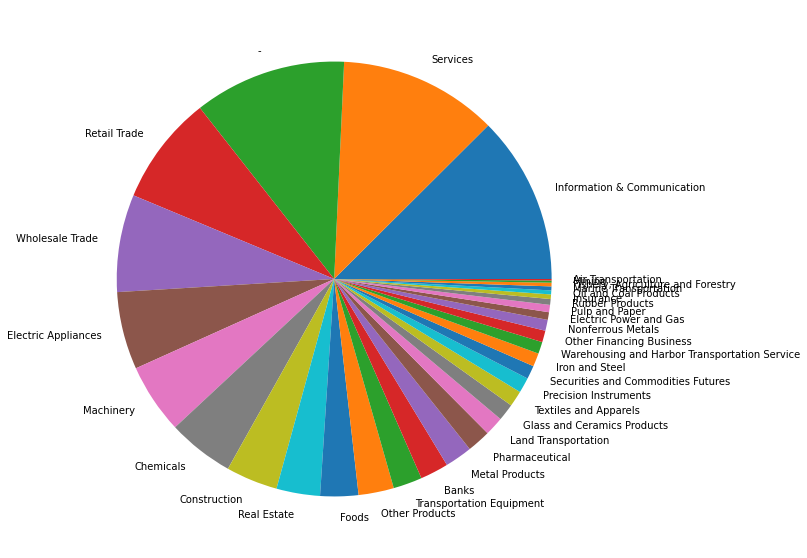

In [46]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(sector["percentage"], labels = sector["index"])
plt.show()

In [47]:
stocks_df["Section/Products"].value_counts()

First Section (Domestic)                                       2327
JASDAQ(Standard / Domestic)                                     726
Second Section(Domestic)                                        530
Mothers (Domestic)                                              439
ETFs/ ETNs                                                      277
REIT, Venture Funds, Country Funds and Infrastructure Funds      68
JASDAQ(Growth/Domestic)                                          41
First Section (Foreign)                                           4
Mothers (Foreign)                                                 3
JASDAQ(Standard / Foreign)                                        1
Second Section(Foreign)                                           1
Name: Section/Products, dtype: int64

In [48]:
section = stocks_df["Section/Products"].value_counts().to_frame()
section.reset_index(inplace=True)
section["percentage"] = section["Section/Products"]/section["Section/Products"].sum()*100
section

,index,Section/Products,percentage
0,First Section (Domestic),2327,52.682816
1,JASDAQ(Standard / Domestic),726,16.436495
2,Second Section(Domestic),530,11.999094
3,Mothers (Domestic),439,9.938873
4,ETFs/ ETNs,277,6.271225
5,"REIT, Venture Funds, Country Funds and Infrastructure Funds",68,1.539506
6,JASDAQ(Growth/Domestic),41,0.928232
7,First Section (Foreign),4,0.090559
8,Mothers (Foreign),3,0.067919
9,JASDAQ(Standard / Foreign),1,0.022640


In [49]:
section["percentage"] = section["Section/Products"]/section["Section/Products"].sum()*100

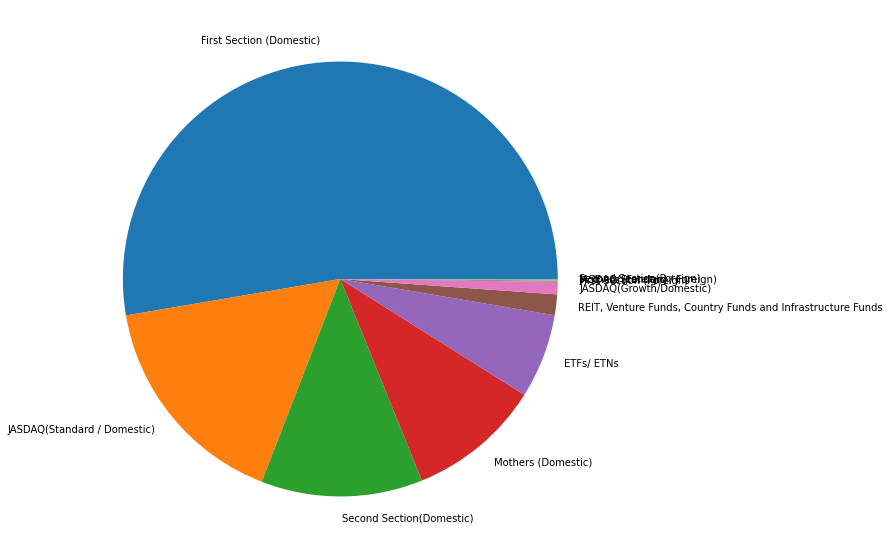

In [50]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(section["percentage"], labels = section["index"])
plt.show()

In [51]:
del sector
del section
gc.collect()

9375

## Selecting the top 2000 Stocks (Universe0 Flag = True)

In [52]:
stocks2000_df = stocks_df[stocks_df["Universe0"]]
display(stocks2000_df.head())

,SecuritiesCode,EffectiveDate,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,TradeDate,Close,IssuedShares,MarketCapitalization,Universe0
0,1301,20211230,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,3080.0,10928283.0,3.365911e+10,True
19,1332,20211230,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,543.0,312430277.0,1.696496e+11,True
20,1333,20211230,Maruha Nichiro Corporation,First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,20211230.0,2405.0,52656910.0,1.266399e+11,True
37,1375,20211230,"YUKIGUNI MAITAKE CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,6,TOPIX Small 1,20211230.0,1196.0,39910700.0,4.773320e+10,True
38,1376,20211230,"KANEKO SEEDS CO.,LTD.",First Section (Domestic),Standard Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,20211230.0,1504.0,11772626.0,1.770603e+10,True


In [53]:
stocks2000_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 4415
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SecuritiesCode          2000 non-null   int64  
 1   EffectiveDate           2000 non-null   int64  
 2   Name                    2000 non-null   object 
 3   Section/Products        2000 non-null   object 
 4   NewMarketSegment        2000 non-null   object 
 5   33SectorCode            2000 non-null   object 
 6   33SectorName            2000 non-null   object 
 7   17SectorCode            2000 non-null   object 
 8   17SectorName            2000 non-null   object 
 9   NewIndexSeriesSizeCode  2000 non-null   object 
 10  NewIndexSeriesSize      2000 non-null   object 
 11  TradeDate               2000 non-null   float64
 12  Close                   2000 non-null   float64
 13  IssuedShares            2000 non-null   float64
 14  MarketCapitalization    2000 non-null   

In [54]:
stocks2000_df["33SectorName"].value_counts()

Information & Communication          229
Services                             201
Retail Trade                         179
Electric Appliances                  156
Wholesale Trade                      151
                                    ... 
Oil and Coal Products                  9
Fishery, Agriculture and Forestry      8
Marine Transportation                  7
Mining                                 5
Air Transportation                     4
Name: 33SectorName, Length: 33, dtype: int64

In [55]:
sector2000 = stocks2000_df["33SectorName"].value_counts().to_frame()
sector2000.reset_index(inplace=True)
sector2000["percentage"] = sector2000["33SectorName"]/sector2000["33SectorName"].sum()*100
sector2000.head(5)

,index,33SectorName,percentage
0,Information & Communication,229,11.45
1,Services,201,10.05
2,Retail Trade,179,8.95
3,Electric Appliances,156,7.80
4,Wholesale Trade,151,7.55


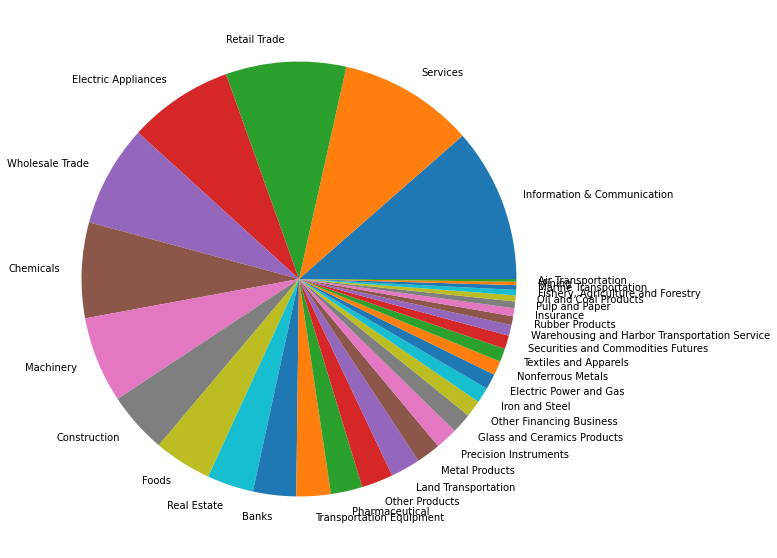

In [56]:
plt.rcParams["figure.figsize"] = (40,10)
plt.pie(sector2000["percentage"], labels = sector2000["index"])
plt.show()

In [57]:
section2000 = stocks2000_df["Section/Products"].value_counts().to_frame()
section2000.reset_index(inplace=True)
section2000["percentage"] = section2000["Section/Products"]/section2000["Section/Products"].sum()*100
section2000

,index,Section/Products,percentage
0,First Section (Domestic),1711,85.55
1,JASDAQ(Standard / Domestic),107,5.35
2,Second Section(Domestic),90,4.50
3,Mothers (Domestic),85,4.25
4,JASDAQ(Growth/Domestic),7,0.35


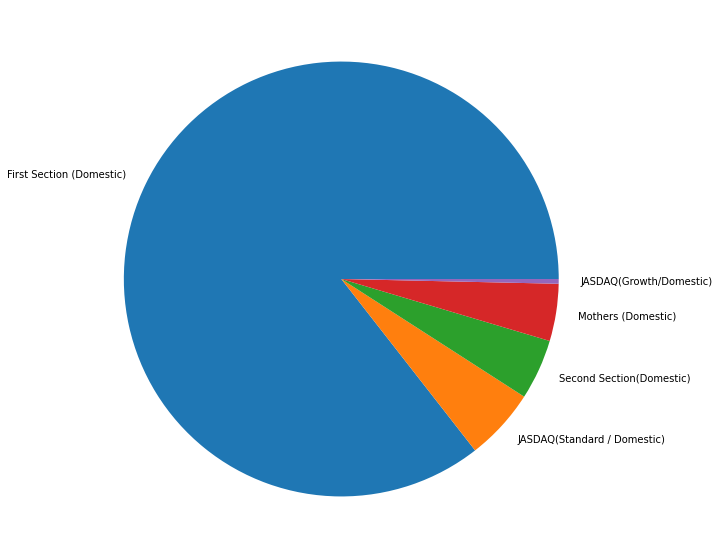

In [58]:
plt.rcParams["figure.figsize"] = (30,10)
plt.pie(section2000["percentage"], labels = section2000["index"])
plt.show()

In [59]:
del stocks_df
del section2000
del sector2000
gc.collect()

8532

## Merging Stock metadate with stock price

In [60]:
df_prices =  merge_metadata(stock_prices_df, stocks2000_df)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10


**Free memory**

del stock_prices_df
del stocks2000_df

gc.collect()

**Calculating Target variable statistics**

In [61]:
mean_securities_df = df_prices.groupby(["SecuritiesCode"])["Target"].mean()
total_mean_securities = mean_securities_df.mean()
total_mean_securities

0.0004714963317502812

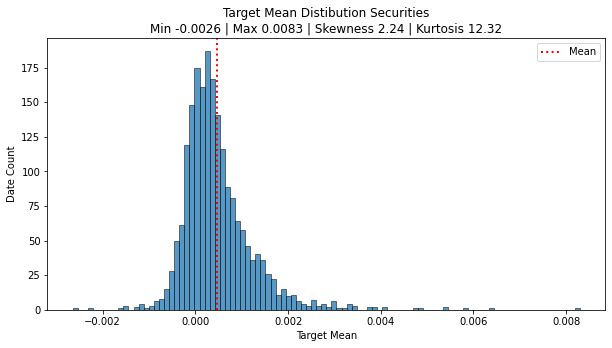

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=mean_securities_df.values, bins=100,
             ax=ax)
ax.axvline(x=total_mean_securities, color='red', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution Securities\n"
             f"Min {round(mean_securities_df.min(), 4)} | "
             f"Max {round(mean_securities_df.max(), 4)} | "
             f"Skewness {round(mean_securities_df.skew(), 2)} | "
             f"Kurtosis {round(mean_securities_df.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

In [63]:
mean_date_df = df_prices.groupby(["Date"])["Target"].mean()
total_mean_date = mean_date_df.mean()
total_mean_date

0.00044572606297777287

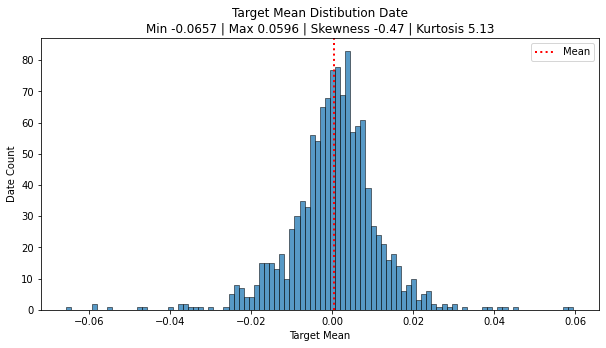

In [64]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=mean_date_df.values, bins=100,
             ax=ax)
ax.axvline(x=total_mean_date, color='red', linestyle='dotted', linewidth=2, 
           label='Mean')
ax.set_title("Target Mean Distibution Date\n"
             f"Min {round(mean_date_df.min(), 4)} | "
             f"Max {round(mean_date_df.max(), 4)} | "
             f"Skewness {round(mean_date_df.skew(), 2)} | "
             f"Kurtosis {round(mean_date_df.kurtosis(), 2)}")
ax.set_xlabel("Target Mean")
ax.set_ylabel("Date Count")
ax.legend()
plt.show()

## Grupying the Target by Sector and Section

### Target vs Sector33

In [65]:
target_sector = df_prices.groupby(["33SectorName"])["Target"].mean()
target_sector.sort_values(inplace=True, ascending=False)


In [66]:
target_sector = target_sector.to_frame()
target_sector.reset_index(inplace= True)

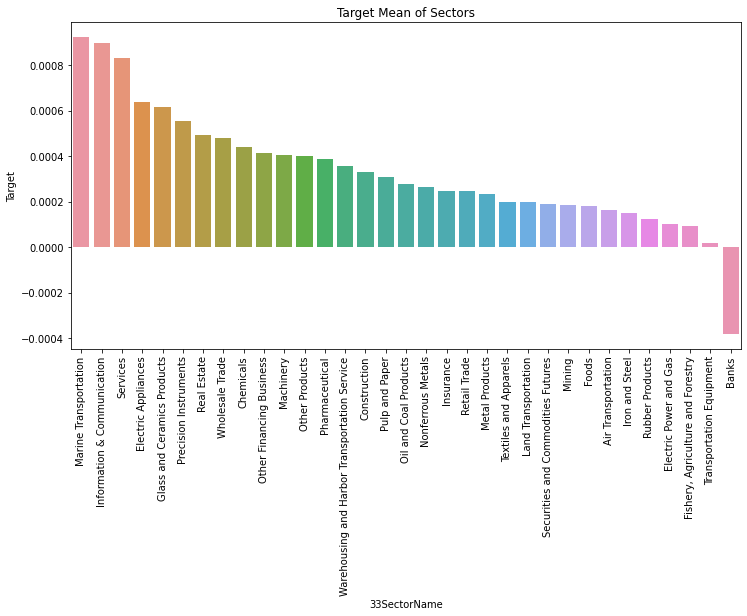

In [67]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "33SectorName", y = "Target", data = target_sector, ax=ax)
ax.set_title("Target Mean of Sectors")
ax.tick_params(axis='x', rotation=90)

### Target vs Section

In [68]:
target_section = df_prices.groupby(["Section/Products"])["Target"].mean()
target_section.sort_values(inplace=True, ascending=False)


In [69]:
target_section = target_section.to_frame()
target_section.reset_index(inplace= True)

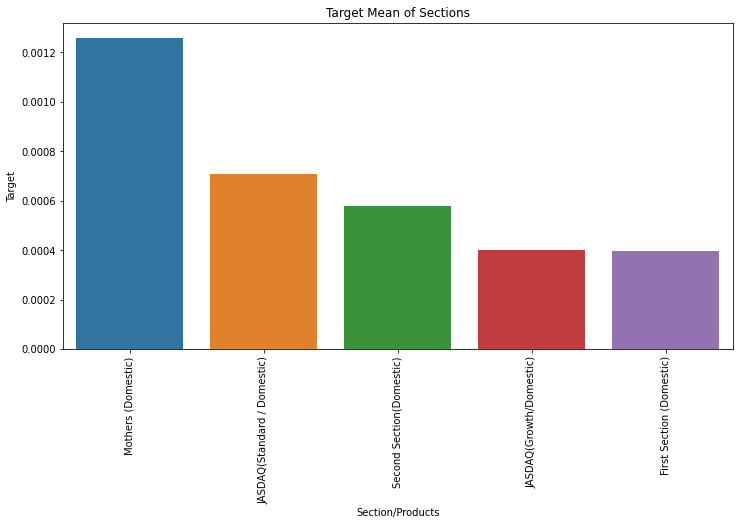

In [70]:
fig, ax = plt.subplots(figsize = (12,6))    
fig = sns.barplot(x = "Section/Products", y = "Target", data = target_section, ax=ax)
ax.set_title("Target Mean of Sections")
ax.tick_params(axis='x', rotation=90)

### Secondary stock prices

Securities with low liquidity (few opportunities to trade)

In [71]:
stock_prices_info

,Column,Sample value,Type,Addendum,Remarks
0,RowId,20170104_1301,string,NaN,Unique ID of price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date
2,SecuritiesCode,1301,Int64,NaN,Local securities code
3,Open,2734,float,NaN,first traded price on a day
4,High,2755,float,NaN,highest traded price on a day
5,Low,2730,float,NaN,lowest traded price on a day
6,Close,2742,float,NaN,last traded price on a day
7,Volume,31400,Int64,NaN,number of traded stocks on a day
8,AdjustmentFactor,1,float,NaN,to calculate theoretical price/volume when split/reverse-split happens (NOT including dividend/allotment of shares/)
9,SupervisionFlag,FALSE,boolean,NaN,Flag of Securities Under Supervision & Securities to Be Delisted\nhttps://www.jpx.co.jp/english/listing/market-alerts/supervision/00-archives/index.html )


In [72]:
display(secondary_stock_prices_df.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1305,2017-01-04,1305,1594.0,1618.0,1594.0,1615.0,538190,1.0,NaN,False,-0.001855
1,20170104_1306,2017-01-04,1306,1575.0,1595.0,1573.0,1593.0,2494980,1.0,NaN,False,-0.000627
2,20170104_1308,2017-01-04,1308,1557.0,1580.0,1557.0,1578.0,526100,1.0,NaN,False,-0.001900
3,20170104_1309,2017-01-04,1309,28810.0,29000.0,28520.0,28780.0,403,1.0,NaN,False,0.005237
4,20170104_1311,2017-01-04,1311,717.0,735.0,717.0,734.0,5470,1.0,NaN,False,0.001359


In [73]:
secondary_stock_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2384575 entries, 0 to 2384574
Data columns (total 12 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   Date              object 
 2   SecuritiesCode    int64  
 3   Open              float64
 4   High              float64
 5   Low               float64
 6   Close             float64
 7   Volume            int64  
 8   AdjustmentFactor  float64
 9   ExpectedDividend  float64
 10  SupervisionFlag   bool   
 11  Target            float64
dtypes: bool(1), float64(7), int64(2), object(2)
memory usage: 202.4+ MB


In [74]:
display(pd.isna(secondary_stock_prices_df).sum()/len(secondary_stock_prices_df)*100)

RowId                0.000000
Date                 0.000000
SecuritiesCode       0.000000
Open                 3.847688
High                 3.847688
Low                  3.847688
Close                3.847688
Volume               0.000000
AdjustmentFactor     0.000000
ExpectedDividend    99.225942
SupervisionFlag      0.000000
Target               0.030110
dtype: float64

**Missing values**

In [75]:
missing_secondary_high = secondary_stock_prices_df[secondary_stock_prices_df["High"].isna()]
display(missing_secondary_high.head(5))

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
68,20170104_1468,2017-01-04,1468,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
83,20170104_1484,2017-01-04,1484,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
86,20170104_1487,2017-01-04,1487,NaN,NaN,NaN,NaN,0,1.0,NaN,False,NaN
118,20170104_1584,2017-01-04,1584,NaN,NaN,NaN,NaN,0,1.0,NaN,False,0.000000
136,20170104_1623,2017-01-04,1623,NaN,NaN,NaN,NaN,0,1.0,NaN,False,-0.022126


In [76]:
missing_secondary_high["Date"].nunique()

1202

In [77]:
plot_missing_secondary_high_df = missing_secondary_high["Date"].value_counts().to_frame().reset_index()
plot_missing_secondary_high_df.rename(columns = {'index':'Date', 'Date':'Count'}, inplace = True)
plot_missing_secondary_high_df.head()

,Date,Count
0,2020-10-01,2009
1,2019-05-22,142
2,2019-08-08,141
3,2019-03-06,141
4,2019-08-29,140


In [78]:
del secondary_stock_prices_df
gc.collect()

27547

As happened with the primary stock list 2020-10-01 is the day with the most amount of missing data


**NOTE:** Secondary stock prices price movement is correlated with the main stock price movement. Due to the limited amount dedicated to this project, this data will not be included in the prediction model

## Trades

Aggregated summary of trading volumes from the previous business week. Following is column information recorded in trades_spec.csv:

    Date: Data published date, usually Thursday on the following week.
    StartDate: The first trading date in this trading week.
    EndDate: The last trading date in this trading week.
    Section: Market division name.

In [79]:
trades_info

,index,Column,Sample value,Type,Addendum,Remarks
0,0,PublishedDate,2017-01-13,date,NaN,"data published data, usually Thursday on the following week."
1,0,StartDate,2017-01-04,date,NaN,The first trading date in this trading week
2,1,EndDate,2017-01-06,date,NaN,The last trading date in this trading week
3,2,Section,Prime Market (First Section),string,NaN,Market division name
4,3,TotalSales,8476800009,Int64,NaN,Please check below documents.\n\nPublished file\nhttps://www.jpx.co.jp/english/markets/statistics-equities/investor-type/b5b4pj000004r9zg-att/stock_val_1_220301.pdf\n\nExplanation of the Trading by Type of Investors\nhttps://www.jpx.co.jp/english/markets/statistics-equities/investor-type/07.html
...,...,...,...,...,...,...
51,50,TrustBanksBalance,-47609502,Int64,NaN,NaN
52,51,OtherFinancialInstitutionsSales,22410692,Int64,NaN,NaN
53,52,OtherFinancialInstitutionsPurchases,21764485,Int64,NaN,NaN
54,53,OtherFinancialInstitutionsTotal,44175177,Int64,NaN,NaN


In [80]:
display(trades_df.head(5))

,Date,StartDate,EndDate,Section,TotalSales,TotalPurchases,TotalTotal,TotalBalance,ProprietarySales,ProprietaryPurchases,ProprietaryTotal,ProprietaryBalance,BrokerageSales,BrokeragePurchases,BrokerageTotal,BrokerageBalance,IndividualsSales,IndividualsPurchases,IndividualsTotal,IndividualsBalance,ForeignersSales,ForeignersPurchases,ForeignersTotal,ForeignersBalance,SecuritiesCosSales,SecuritiesCosPurchases,SecuritiesCosTotal,SecuritiesCosBalance,InvestmentTrustsSales,InvestmentTrustsPurchases,InvestmentTrustsTotal,InvestmentTrustsBalance,BusinessCosSales,BusinessCosPurchases,BusinessCosTotal,BusinessCosBalance,OtherInstitutionsSales,OtherInstitutionsPurchases,OtherInstitutionsTotal,OtherInstitutionsBalance,InsuranceCosSales,InsuranceCosPurchases,InsuranceCosTotal,InsuranceCosBalance,CityBKsRegionalBKsEtcSales,CityBKsRegionalBKsEtcPurchase,CityBKsRegionalBKsEtcTotal,CityBKsRegionalBKsEtcBalance,TrustBanksSales,TrustBanksPurchases,TrustBanksTotal,TrustBanksBalance,OtherFinancialInstitutionsSales,OtherFinancialInstitutionsPurchases,OtherFinancialInstitutionsTotal,OtherFinancialInstitutionsBalance
0,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**NOTE:** Trade volumen info can be used to predict the Target value. Due to the limited amount dedicated to this project, this data will not be included in the prediction model

### Financials 

In [81]:
financials_info

,Column,Sample value,Type,Addendum,Remarks
0,DisclosureNumber,20161025419878,Int64,NaN,Unique ID for disclosure documents.
1,DateCode,20170106_7888,string,NaN,combination of TradeDate and LocalCode (this is not unique for stock_fin as a company can disclose multiple documents on a day)
2,Date,2017-01-06 0:00:00,date,NaN,Trade date. This column is used to align with stock_price's TradeDate
3,SecuritiesCode,7888,Int64,NaN,Local Securities Code
4,DisclosedDate,2017-01-06 0:00:00,date,NaN,Date on which the document disclosed.
...,...,...,...,...,...
40,ChangesInAccountingEstimates,FALSE,boolean,"TRUE, FALSE, or blank","Changes in accounting estimates. (changes in accounting estimates that had been made for the preparation of consolidated financial statements for the previous consolidated fiscal year or any prior consolidated fiscal year, or quarterly consolidated financial statements for the immediately preceding or prior quarterly consolidated accounting period or cumulative quarterly consolidated accounting period based on new information that has become available)"
41,RetrospectiveRestatement,FALSE,boolean,"TRUE, FALSE, or blank","The reflection, in consolidated financial statements or quarterly consolidated financial statements, of the correction of an error in consolidated financial statements for the previous consolidated fiscal year or any prior consolidated fiscal year or quarterly consolidated financial statements for the immediately preceding or prior quarterly consolidated accounting period or cumulative quarterly consolidated accounting period.\n\n[Note] Blank if is difficult to distinguish changes in accounting policies from changes in accounting estimates."
42,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,25688569,Int64,Actual value for the current accounting period.,Number of issued shares at the end of the period (including treasury shares) as of the current accounting period.
43,NumberOfTreasuryStockAtTheEndOfFiscalYear,203627,Int64,Actual value for the current accounting period.,Number of treasury shares at the end of the period as of the current accounting period.


In [82]:
financials_df.head()

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,NetSales,OperatingProfit,OrdinaryProfit,Profit,EarningsPerShare,TotalAssets,Equity,EquityToAssetRatio,BookValuePerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingProfit,ForecastOrdinaryProfit,ForecastProfit,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,2016-04-01,2017-03-31,22761000000,2147000000,2234000000,1494000000,218.23,22386000000.0,18295000000.0,0.817,2671.42,－,50.0,－,NaN,NaN,NaN,NaN,NaN,50.0,100.0,31800000000,3255000000,3300000000,2190000000,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,2016-03-01,2017-02-28,22128000000,820000000,778000000,629000000,328.57,25100000000.0,7566000000.0,0.301,NaN,－,36.0,－,NaN,NaN,NaN,NaN,NaN,36.0,72.0,30200000000,1350000000,1300000000,930000000,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0
2,2.016123e+13,20170104_4575,2017-01-04,4575.0,2017-01-04,12:00:00,1.483499e+09,ForecastRevision,2016-12-31,2Q,2016-07-01,2017-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110000000,-465000000,-466000000,-467000000,-93.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.017010e+13,20170105_2659,2017-01-05,2659.0,2017-01-05,15:00:00,1.483596e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,2016-03-01,2017-02-28,134781000000,11248000000,11558000000,7171000000,224.35,128464000000.0,100905000000.0,0.765,3073.12,－,0.0,－,NaN,NaN,NaN,NaN,NaN,42.0,42.0,177683000000,14168000000,14473000000,9111000000,285.05,NaN,False,True,False,False,False,31981654.0,18257,31963405.0
4,2.017011e+13,20170105_3050,2017-01-05,3050.0,2017-01-05,15:30:00,1.483598e+09,ForecastRevision,2017-02-28,FY,2016-02-29,2017-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,－,－,13.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
financials_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92956 entries, 0 to 92955
Data columns (total 45 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   DisclosureNumber                                                              92954 non-null  float64
 1   DateCode                                                                      92954 non-null  object 
 2   Date                                                                          92956 non-null  object 
 3   SecuritiesCode                                                                92954 non-null  float64
 4   DisclosedDate                                                                 92954 non-null  object 
 5   DisclosedTime                                                                 92954 non-null  object 
 6   DisclosedUnixTime             

In [84]:
display(pd.isna(financials_df).sum()/len(financials_df)*100)

DisclosureNumber                                                                 0.002152
DateCode                                                                         0.002152
Date                                                                             0.000000
SecuritiesCode                                                                   0.002152
DisclosedDate                                                                    0.002152
                                                                                  ...    
ChangesInAccountingEstimates                                                    20.256896
RetrospectiveRestatement                                                        24.269547
NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock    19.404880
NumberOfTreasuryStockAtTheEndOfFiscalYear                                       19.404880
AverageNumberOfShares                                                           20.016997
Length: 45

Notably a high amount of data is missing in financials_df

**NOTE:** Leveraging the financial data in the Fundamental analysis is one popular method in target calculation. Due to the limited amount dedicated to this project, this data will not be included in the prediction model

### Options

**File Description**

Data on the status of a variety of options based on the broader market. Many options include implicit predictions of the future price of the stock market and so may be of interest even though the options are not scored directly. Following is column information recorded in options_spec.csv:

    DateCode: Unique ID for option price records, the combintion of Date and OptionCode.
    Date: Trade date and time.
    OptionsCode: Local securities code. Detailed information is provided in Identification Code Specifications for Futures and Options Transactionssakimono20220208-e.pdf).
    WholeDayOpen: Opening price for whole trading day.
    WholeDayHigh: Highest price for whole trading day.
    WholeDayLow: Lowest price for whole trading day.
    WholeDayClose: Closing price for whole trading day.
    NightSessionOpen: Opening price for night session.
    NightSessionHigh: Highest price for night session.
    NightSessionLow: Lowest price for night session.
    NightSessionClose: Closing price for night session.
    DaySessionOpen: Opening price for day session.
    DaySessionHigh: Highest price for day session.
    DaySessionLow: Lowest price for day session.
    DaySessionClose: Closing price for day session.
    TradingVolume: Trading volume of the product/contract for the whole trading day.
    OpenInterest: Open interest of the product/contract for the whole trading day
    TradingValue: Trading value of the product/contract for the whole trading day
    ContractMonth: Cotract year-month of the product/contract.
    StrikePrice: Exercise price of product/contract.
    DaySessionVolume: Trading volume of the product/contract for day session.
    Putcall: 1 for put and 2 for call.
    LastTradingDay: Last trading day.
    SpecialQuotationDay: The day when the Special Quotation is calculated.
    SettlementPrice: Settlement price.
    TheoreticalPrice: The theoretical price at the end of a day session.
    BaseVolatility: The volatility at the time of calculating the settlement price.
    ImpliedVolatility: Implied volatility.
    InterestRate: Interest rate for calculation.
    DividendRate: Dividend yeild.
    Dividend: Devidend.

In [85]:
options_info

,Column,Sample value,Type,Addendum,Remarks
0,DateCode,20170104_144122718,string,NaN,Unique ID for option price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date and time
2,OptionsCode,144122718,string,NaN,Local Securities Code (link to https://www.jpx.co.jp/english/sicc/regulations/b5b4pj0000023mqo-att/(HP)sakimono20220208-e.pdf )
3,WholeDayOpen,0,float,NaN,Opening Price for Whole Trading Day
4,WholeDayHigh,0,float,NaN,High Price for Whole Trading Day
...,...,...,...,...,...
26,BaseVolatility,17.4736,float,NaN,The volatility at the time of calculating the settlement price
27,ImpliedVolatility,26.0651,float,NaN,Implied Volatility
28,InterestRate,0.1282,float,NaN,Interest rate for calculation
29,DividendRate,1.6817,float,NaN,Dividendv yeild


In [86]:
options_df.head()

,DateCode,Date,OptionsCode,WholeDayOpen,WholeDayHigh,WholeDayLow,WholeDayClose,NightSessionOpen,NightSessionHigh,NightSessionLow,NightSessionClose,DaySessionOpen,DaySessionHigh,DaySessionLow,DaySessionClose,TradingVolume,OpenInterest,TradingValue,ContractMonth,StrikePrice,WholeDayVolume,Putcall,LastTradingDay,SpecialQuotationDay,SettlementPrice,TheoreticalPrice,BaseVolatility,ImpliedVolatility,InterestRate,DividendRate,Dividend
0,20170104_132010018,2017-01-04,132010018,650.0,650.0,480.0,480.0,0.0000,0.0000,0.0000,0.0000,650.0,650.0,480.0,480.0,6,19,3455000,201701,20000.0,6,1,20170112,20170113,480.0,478.4587,17.4736,17.5865,0.0091,0.0,0.0
1,20170104_132010118,2017-01-04,132010118,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20125.0,0,1,20170112,20170113,575.0,571.1385,17.4736,16.5000,0.0091,0.0,0.0
2,20170104_132010218,2017-01-04,132010218,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,5,0,201701,20250.0,0,1,20170112,20170113,680.0,677.3710,17.4736,15.8644,0.0091,0.0,0.0
3,20170104_132010318,2017-01-04,132010318,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,1,0,201701,20375.0,0,1,20170112,20170113,795.0,791.0383,17.4736,15.2288,0.0091,0.0,0.0
4,20170104_132010518,2017-01-04,132010518,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0,0,0,201701,20500.0,0,1,20170112,20170113,910.0,909.9947,17.4736,14.5932,0.0091,0.0,0.0


In [87]:
options_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3567694 entries, 0 to 3567693
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   DateCode             object 
 1   Date                 object 
 2   OptionsCode          int64  
 3   WholeDayOpen         float64
 4   WholeDayHigh         float64
 5   WholeDayLow          float64
 6   WholeDayClose        float64
 7   NightSessionOpen     object 
 8   NightSessionHigh     object 
 9   NightSessionLow      object 
 10  NightSessionClose    object 
 11  DaySessionOpen       float64
 12  DaySessionHigh       float64
 13  DaySessionLow        float64
 14  DaySessionClose      float64
 15  TradingVolume        int64  
 16  OpenInterest         int64  
 17  TradingValue         int64  
 18  ContractMonth        int64  
 19  StrikePrice          float64
 20  WholeDayVolume       int64  
 21  Putcall              int64  
 22  LastTradingDay       int64  
 23  SpecialQuotationDay  int64  
 24

**NOTE:** Info provided by Options (for instance the put/call volumen ratio) is interesting to determine the market feeling about a particular derivated product. Due to the limited amount dedicated to this project, this data will not be included in the prediction model

## 2. Data wrangling
- Adjust OHLC prices (Split- Reverse/split)
- Input missing values


#### Generate adjusted OHLC prices
Generate adjusted OHLC prices using AdjustmentFactor attribute. This should reduce historical price gap caused by split/reverse-split.

Furthermore, adjust_price() also inputs the missing data

In [88]:
df_prices_adj = adjust_price(df_prices)
df_prices_adj.head(5)

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow
0,20170104_1301,2017-01-04,1301,31400,NaN,False,0.000730,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2742.0,2734.0,2755.0,2730.0
1,20170105_1301,2017-01-05,1301,17900,NaN,False,0.002920,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2738.0,2743.0,2747.0,2735.0
2,20170106_1301,2017-01-06,1301,19900,NaN,False,-0.001092,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2740.0,2734.0,2744.0,2720.0
3,20170110_1301,2017-01-10,1301,24200,NaN,False,-0.005100,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2748.0,2745.0,2754.0,2735.0
4,20170111_1301,2017-01-11,1301,9300,NaN,False,-0.003295,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10,1.0,2745.0,2748.0,2752.0,2737.0


In [89]:
df_prices_adj["CumulativeAdjustmentFactor"].value_counts()

1.000000     2063087
0.500000      123655
0.250000       31860
5.000000       30099
10.000000      25106
              ...   
0.142857         106
0.692641          98
0.384615          90
0.620921          58
0.631313          36
Name: CumulativeAdjustmentFactor, Length: 41, dtype: int64

In [90]:
df_prices_adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 23 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   RowId                       object        
 1   Date                        datetime64[ns]
 2   SecuritiesCode              int64         
 3   Volume                      int64         
 4   ExpectedDividend            float64       
 5   SupervisionFlag             bool          
 6   Target                      float64       
 7   Name                        object        
 8   Section/Products            object        
 9   NewMarketSegment            object        
 10  33SectorCode                object        
 11  33SectorName                object        
 12  17SectorCode                object        
 13  17SectorName                object        
 14  NewIndexSeriesSizeCode      object        
 15  NewIndexSeriesSize          object        
 16  IssuedShares      

**Less missing values**

In [91]:
display(pd.isna(df_prices_adj).sum()/len(df_prices_adj)*100)

RowId                          0.000000
Date                           0.000000
SecuritiesCode                 0.000000
Volume                         0.000000
ExpectedDividend              99.191222
SupervisionFlag                0.000000
Target                         0.010204
Name                           0.000000
Section/Products               0.000000
NewMarketSegment               0.000000
33SectorCode                   0.000000
33SectorName                   0.000000
17SectorCode                   0.000000
17SectorName                   0.000000
NewIndexSeriesSizeCode         0.000000
NewIndexSeriesSize             0.000000
IssuedShares                   0.000000
MarketCapitalization           0.000000
CumulativeAdjustmentFactor     0.000000
AdjustedClose                  0.000429
AdjustedOpen                   0.000429
AdjustedHigh                   0.000429
AdjustedLow                    0.000429
dtype: float64

**Now the OHTC chart shows continuity**

Before adjustment

In [92]:
plot_candle_with_target(df_prices, 9726) 

After adjustment

In [93]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 9726) 

Before adjustment

In [94]:
plot_candle_with_target(df_prices, 4582)

After adjustment

In [95]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 4582) 

Before adjustment

In [96]:
plot_candle_with_target(df_prices, 1805)

After adjustment

In [97]:
plot_candle_with_target_adjusted(adjust_price(df_prices), 1805) 

## 3. Feature Engineering
- Create basic statics
    1. Moving average
    2. Exponential moving average
    3. volatility
- Do not create Features since you are going to be using RNN
- Merge sentiment analysis data from Options
    1. https://www.boerse-stuttgart.de/de-de/tools/euwax-sentiment/
    2. https://www-mmds.sigmath.es.osaka-u.ac.jp/en/activity/vxj.php#:~:text=The%20Volatility%20Index%20Japan%20(VXJ,based%20on%20Nikkei225%20index%20options.
- Check correlation secondary stock market target vs Primary stock market target


**Correlogram to see if there is any autocorrelation**

In [98]:
df_9726 =df_prices_adj[df_prices_adj["SecuritiesCode"]==9726]

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

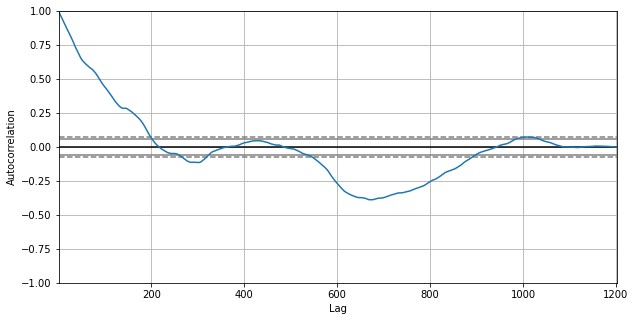

In [99]:
plt.rcParams['figure.figsize'] = [10, 5]
pd.plotting.autocorrelation_plot(df_9726["AdjustedClose"])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

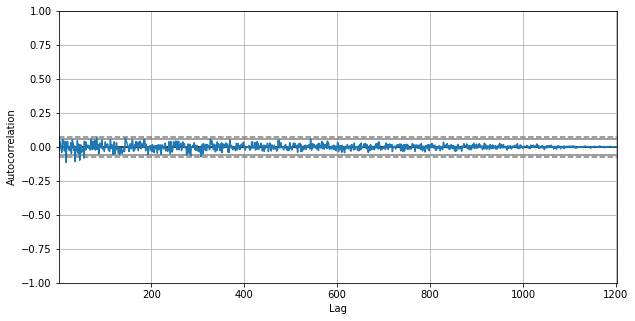

In [100]:
pd.plotting.autocorrelation_plot(df_9726["Target"])

It certainly look like we are dealing with a random walk, as there are no indications of any autocorrelation for any lag.

Basically our LSTM found nothing of any real value to model and thus took the average value, along with a slight slope; we would have been just as well off with an extremely simplistic model of the form

C
l
o
s
e
t
∝
C
l
o
s
e
(
t
−
1
)

Price is correlated but price change shows no correlation. Therefore, the target variable itself will not give us much info about future stock movements... We need a good Feature engineering

### Feature Engineering

**From adjusted prices (individual)**
- Price changes
- Moving average
- Exponential moving average
- Volatility
- One hot encoding
- Standarization?

**Price changes**


In [101]:
period = [5,10,21,33]

In [102]:
for i in period:
    df_9726[f"pct{i}"] = df_9726["AdjustedClose"].pct_change(i)
display(df_9726.head(5))

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,pct10,pct21,pct33
2245987,20170104_9726,2017-01-04,9726,472000,NaN,False,0.013605,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1470.0,1460.0,1480.0,1450.0,NaN,NaN,NaN,NaN
2245988,20170105_9726,2017-01-05,9726,420000,NaN,False,0.020134,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1470.0,1480.0,1490.0,1470.0,NaN,NaN,NaN,NaN
2245989,20170106_9726,2017-01-06,9726,462000,NaN,False,-0.006579,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1490.0,1470.0,1490.0,1470.0,NaN,NaN,NaN,NaN
2245990,20170110_9726,2017-01-10,9726,1170000,NaN,False,-0.006623,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1520.0,1500.0,1530.0,1490.0,NaN,NaN,NaN,NaN
2245991,20170111_9726,2017-01-11,9726,797000,NaN,False,0.006667,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,10.0,1510.0,1530.0,1530.0,1490.0,NaN,NaN,NaN,NaN


**Simple Moving Average (SMA)**

In [103]:
period_avg = [10,20,50,60]

In [104]:
for i in period_avg:
    df_9726[f"SMA_{i}"] = df_9726['AdjustedClose'].rolling(window=i).mean()

display(df_9726.tail(5))

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,pct10,pct21,pct33,SMA_10,SMA_20,SMA_50,SMA_60
2247184,20211129_9726,2021-11-29,9726,220200,NaN,False,-0.002833,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1405.0,1447.0,1473.0,1403.0,-0.155141,-0.204417,-0.139093,-0.199430,1653.9,1694.80,1671.82,1623.783333
2247185,20211130_9726,2021-11-30,9726,146700,NaN,False,-0.086648,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1412.0,1444.0,1478.0,1407.0,-0.140596,-0.207187,-0.140596,-0.182870,1617.0,1681.70,1672.02,1624.983333
2247186,20211201_9726,2021-12-01,9726,77400,NaN,False,0.095645,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1408.0,1401.0,1429.0,1382.0,-0.119450,-0.227647,-0.158901,-0.168831,1575.5,1668.95,1672.06,1626.200000
2247187,20211202_9726,2021-12-02,9726,273800,NaN,False,0.022001,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1286.0,1228.0,1318.0,1228.0,-0.191703,-0.273446,-0.226699,-0.233154,1527.1,1645.90,1670.62,1625.366667
2247188,20211203_9726,2021-12-03,9726,141500,NaN,False,0.044444,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1409.0,1316.0,1409.0,1316.0,-0.070580,-0.193936,-0.193475,-0.155782,1493.2,1629.85,1670.62,1626.033333


**Exponential Moving Average (EMA)**

In [105]:
for i in period_avg:
    df_9726[f"EMA_{i}"] = df_9726['AdjustedClose'].ewm(span=i,adjust=False).mean()

display(df_9726.tail(5))

,RowId,Date,SecuritiesCode,Volume,ExpectedDividend,SupervisionFlag,Target,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,pct10,pct21,pct33,SMA_10,SMA_20,SMA_50,SMA_60,EMA_10,EMA_20,EMA_50,EMA_60
2247184,20211129_9726,2021-11-29,9726,220200,NaN,False,-0.002833,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1405.0,1447.0,1473.0,1403.0,-0.155141,-0.204417,-0.139093,-0.199430,1653.9,1694.80,1671.82,1623.783333,1606.162071,1652.448618,1627.698192,1607.672109
2247185,20211130_9726,2021-11-30,9726,146700,NaN,False,-0.086648,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1412.0,1444.0,1478.0,1407.0,-0.140596,-0.207187,-0.140596,-0.182870,1617.0,1681.70,1672.02,1624.983333,1570.859876,1629.548750,1619.239439,1601.256630
2247186,20211201_9726,2021-12-01,9726,77400,NaN,False,0.095645,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1408.0,1401.0,1429.0,1382.0,-0.119450,-0.227647,-0.158901,-0.168831,1575.5,1668.95,1672.06,1626.200000,1541.248989,1608.448869,1610.955539,1594.920347
2247187,20211202_9726,2021-12-02,9726,273800,NaN,False,0.022001,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1286.0,1228.0,1318.0,1228.0,-0.191703,-0.273446,-0.226699,-0.233154,1527.1,1645.90,1670.62,1625.366667,1494.840082,1577.739453,1598.212185,1584.791812
2247188,20211203_9726,2021-12-03,9726,141500,NaN,False,0.044444,"KNT-CT Holdings Co.,Ltd.",First Section (Domestic),Standard Market,9050,Services,10,"IT & SERVICES, OTHERS",7,TOPIX Small 2,27331013.0,3.799011e+10,1.0,1409.0,1316.0,1409.0,1316.0,-0.070580,-0.193936,-0.193475,-0.155782,1493.2,1629.85,1670.62,1626.033333,1479.232795,1561.669029,1590.792099,1579.028146


Plotting the new features

In [106]:
col_avg = ["AdjustedClose","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_20","EMA_60"]

In [107]:
df_9726Avg = df_9726[col_avg]
df_9726Avg.head()

,AdjustedClose,SMA_10,SMA_20,SMA_50,SMA_60,EMA_10,EMA_20,EMA_20,EMA_60
2245987,1470.0,NaN,NaN,NaN,NaN,1470.000000,1470.000000,1470.000000,1470.000000
2245988,1470.0,NaN,NaN,NaN,NaN,1470.000000,1470.000000,1470.000000,1470.000000
2245989,1490.0,NaN,NaN,NaN,NaN,1473.636364,1471.904762,1471.904762,1470.655738
2245990,1520.0,NaN,NaN,NaN,NaN,1482.066116,1476.485261,1476.485261,1472.273582
2245991,1510.0,NaN,NaN,NaN,NaN,1487.145004,1479.677141,1479.677141,1473.510514


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

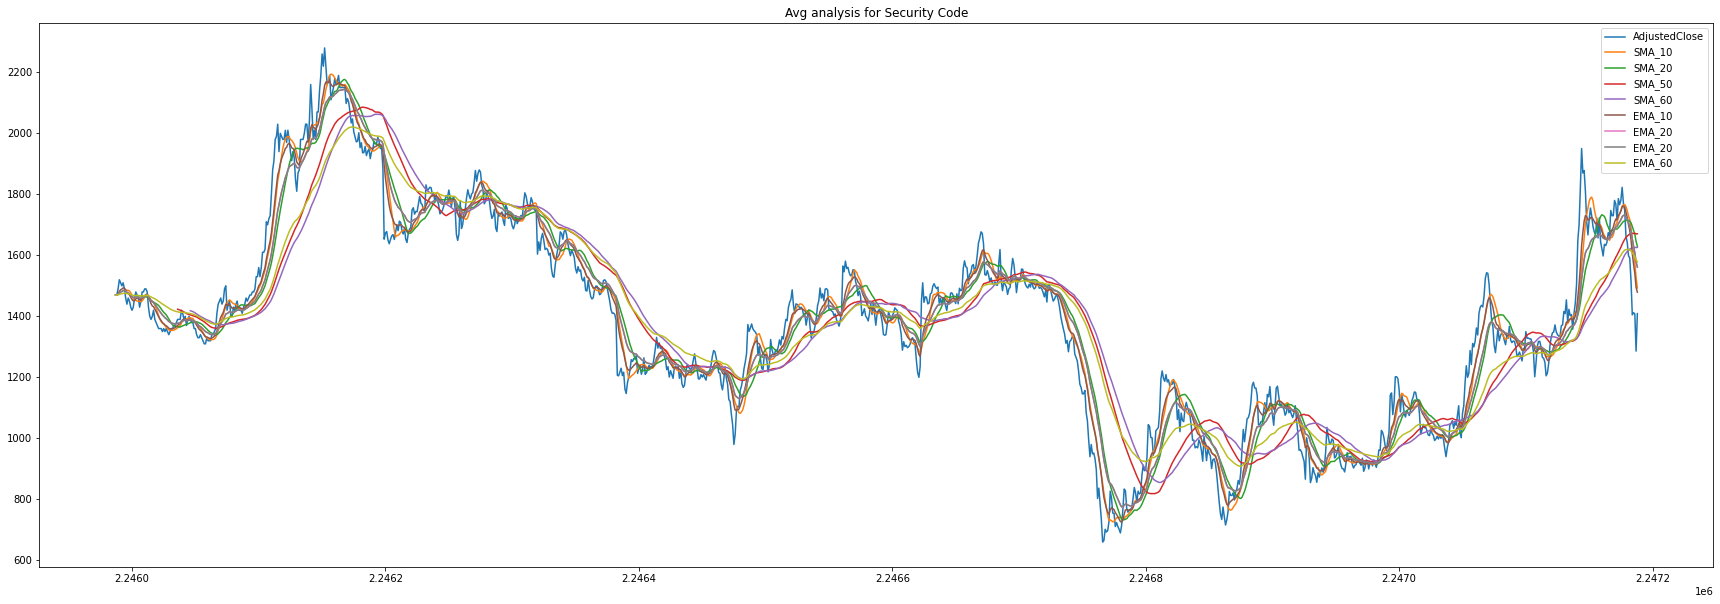

In [108]:
plt.rcParams["figure.figsize"] = (30,10)
df_9726Avg.plot(title = "Avg analysis for Security Code")

In [109]:
col_SMA = ["AdjustedClose","SMA_10","SMA_20","SMA_50","SMA_60"]

In [110]:
df_9726SMA = df_9726[col_SMA]
df_9726SMA.head()

,AdjustedClose,SMA_10,SMA_20,SMA_50,SMA_60
2245987,1470.0,NaN,NaN,NaN,NaN
2245988,1470.0,NaN,NaN,NaN,NaN
2245989,1490.0,NaN,NaN,NaN,NaN
2245990,1520.0,NaN,NaN,NaN,NaN
2245991,1510.0,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

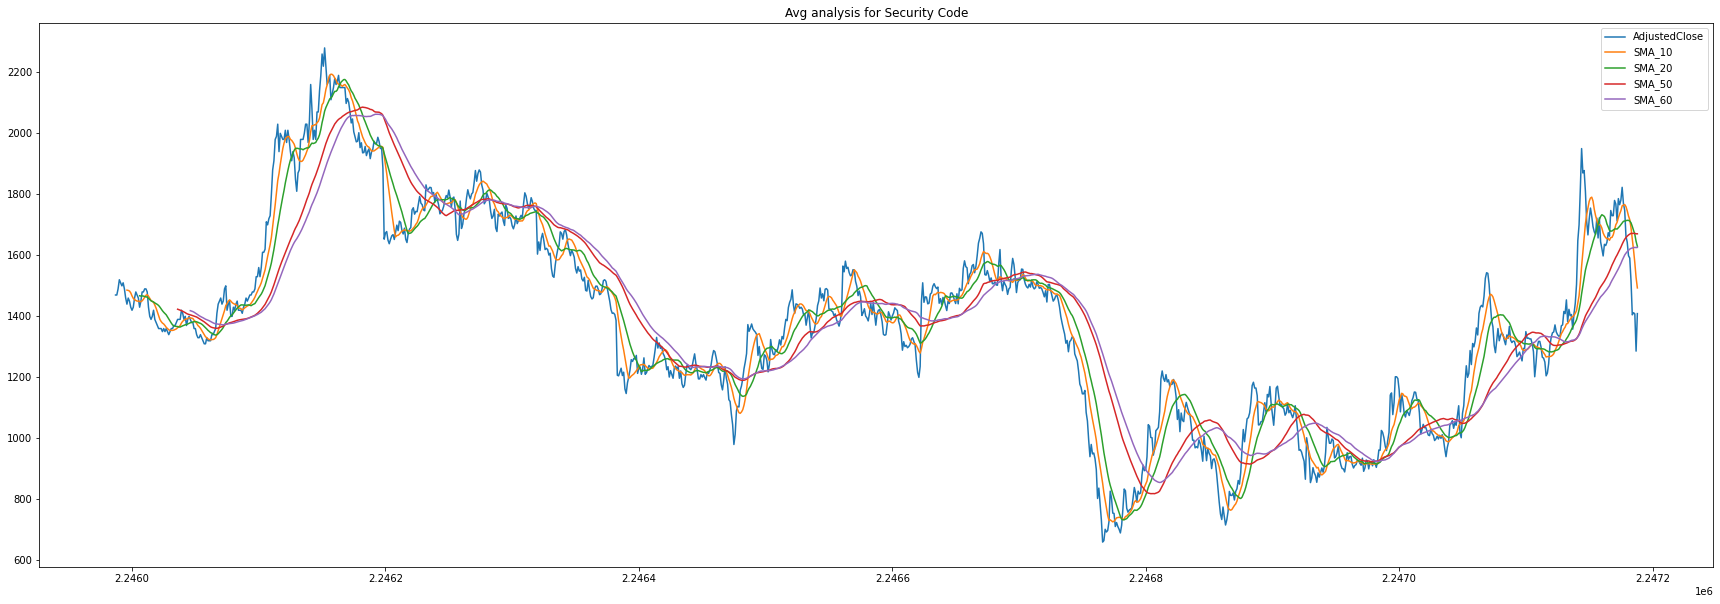

In [111]:
df_9726SMA.plot(title = "Avg analysis for Security Code")

In [112]:
col_EMA = ["AdjustedClose","EMA_10","EMA_20","EMA_50","EMA_60"]

In [113]:
df_9726EMA = df_9726[col_EMA]
df_9726EMA.head()

,AdjustedClose,EMA_10,EMA_20,EMA_50,EMA_60
2245987,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
2245988,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
2245989,1490.0,1473.636364,1471.904762,1470.784314,1470.655738
2245990,1520.0,1482.066116,1476.485261,1472.714341,1472.273582
2245991,1510.0,1487.145004,1479.677141,1474.176523,1473.510514


<AxesSubplot:title={'center':'Avg analysis for Security Code'}>

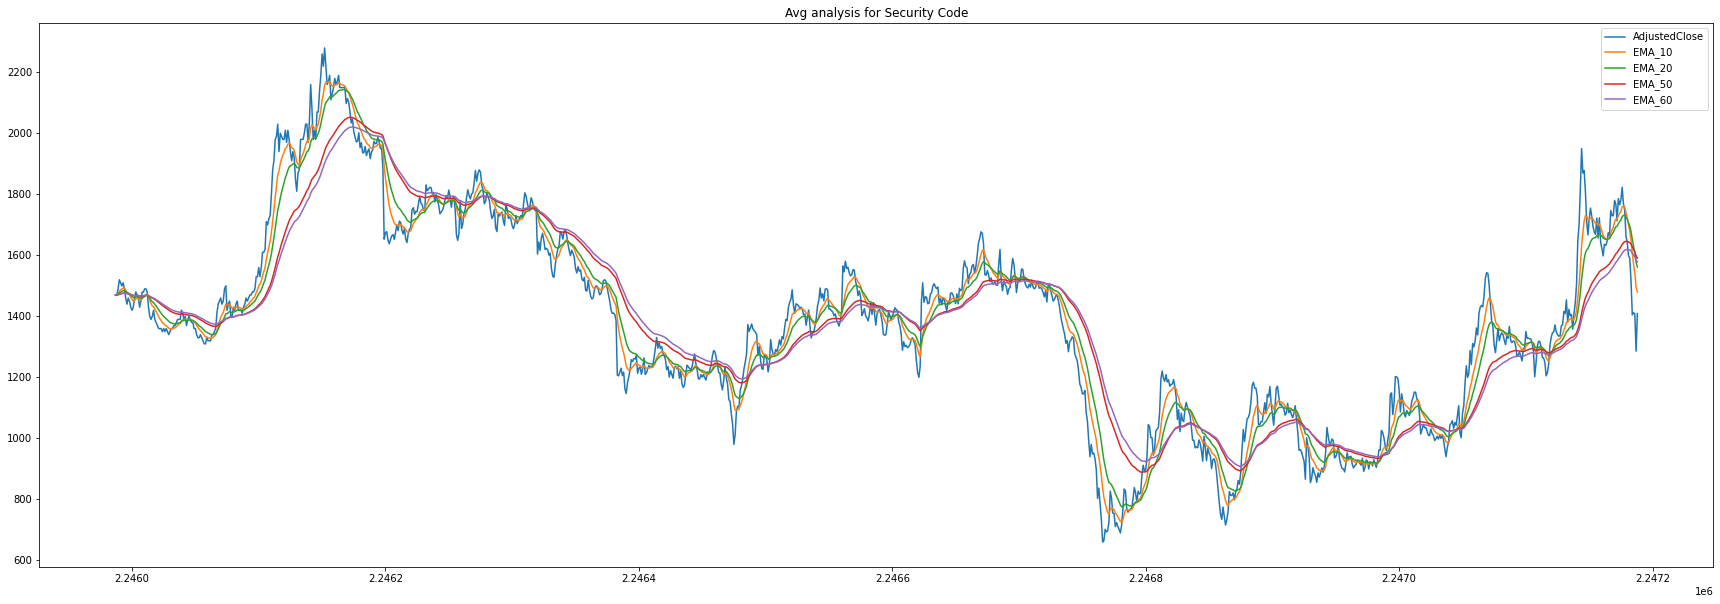

In [114]:
df_9726EMA.plot(title = "Avg analysis for Security Code")

In [115]:
df_prices_feat = generate_feature(df_prices_adj)
df_prices_feat.drop(["RowId","ExpectedDividend","Name","Section/Products","SupervisionFlag","NewMarketSegment","33SectorCode","17SectorCode","NewIndexSeriesSizeCode","NewIndexSeriesSize","IssuedShares","MarketCapitalization"],axis=1,inplace=True)
df_prices_feat.head(5)

,Date,SecuritiesCode,Volume,Target,33SectorName,17SectorName,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,pct5,Volatility_5,pct10,Volatility_10,pct21,Volatility_21,pct33,Volatility_33,SMA_10,EMA_10,SMA_20,EMA_20,SMA_50,EMA_50,SMA_60,EMA_60
0,2017-01-04,1301,31400,0.000730,"Fishery, Agriculture and Forestry",FOODS,1.0,2742.0,2734.0,2755.0,2730.0,0.004028,0.002969,0.015932,0.003732,0.008088,0.004796,-0.048577,0.005294,2725.0,2733.158949,2725.75,2741.853831,2847.54,2815.764772,2891.566667,2838.160046
1,2017-01-05,1301,17900,0.002920,"Fishery, Agriculture and Forestry",FOODS,1.0,2738.0,2743.0,2747.0,2735.0,0.005878,0.003178,0.000365,0.006179,0.004771,0.004813,-0.064571,0.005795,2720.7,2731.194271,2725.10,2741.838444,2855.90,2818.775579,2894.800000,2841.419708
2,2017-01-06,1301,19900,-0.001092,"Fishery, Agriculture and Forestry",FOODS,1.0,2740.0,2734.0,2744.0,2720.0,0.013314,0.003734,0.007353,0.006468,0.003295,0.004838,-0.064208,0.005799,2720.6,2729.681887,2724.20,2742.242491,2865.04,2822.072541,2899.333333,2844.925461
3,2017-01-10,1301,24200,-0.005100,"Fishery, Agriculture and Forestry",FOODS,1.0,2748.0,2745.0,2754.0,2735.0,0.023083,0.002383,0.007701,0.006448,0.004019,0.004818,-0.066893,0.005834,2718.6,2727.388973,2723.45,2742.478543,2873.94,2825.422441,2903.833333,2848.482256
4,2017-01-11,1301,9300,-0.003295,"Fishery, Agriculture and Forestry",FOODS,1.0,2745.0,2748.0,2752.0,2737.0,0.018931,0.004005,0.005126,0.006484,0.002923,0.004813,-0.068228,0.005815,2716.5,2722.808745,2722.60,2741.897337,2881.98,2828.582540,2908.116667,2851.888435


In [116]:
df_prices_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2332531 entries, 0 to 2332530
Data columns (total 27 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Date                        datetime64[ns]
 1   SecuritiesCode              int64         
 2   Volume                      int64         
 3   Target                      float64       
 4   33SectorName                object        
 5   17SectorName                object        
 6   CumulativeAdjustmentFactor  float64       
 7   AdjustedClose               float64       
 8   AdjustedOpen                float64       
 9   AdjustedHigh                float64       
 10  AdjustedLow                 float64       
 11  pct5                        float64       
 12  Volatility_5                float64       
 13  pct10                       float64       
 14  Volatility_10               float64       
 15  pct21                       float64       
 16  Volatility_21     

In [117]:
del df_prices_adj
del df_9726
del df_9726EMA
del df_9726SMA
del options_df
del financials_df
del trades_df
del financials_info
del options_info
del stock_prices_info
del trades_info
del stocks_info
gc.collect()

66

In [118]:
del target_sector
del target_section
gc.collect()

23

**Feature engineering by Group --> One Hot encoding**
- SectorCode33
- Section

In [119]:
def encoding(df):
    cat_encoder = OneHotEncoder(handle_unknown='ignore')
    train_set_cat_coded = cat_encoder.fit_transform(df[["33SectorName","17SectorName"]])
    ls=[]
    for i in cat_encoder.categories_:
        for j in i:
            ls.append(j)

    train_set_cat_coded_ready = pd.DataFrame(train_set_cat_coded.todense(),columns = ls,index=df.index)
    for i in train_set_cat_coded_ready.columns.to_list():
        train_set_cat_coded_ready[i] = train_set_cat_coded_ready[i].apply(np.int64)
    
    df = pd.concat([df, train_set_cat_coded_ready], axis=1)
    del train_set_cat_coded
    del train_set_cat_coded_ready
    return df

In [120]:
cat_encoder = OneHotEncoder(handle_unknown='ignore')
train_set_cat_coded = cat_encoder.fit_transform(df_prices_feat[["33SectorName","17SectorName"]])
train_set_cat_coded.shape

(2332531, 50)

In [121]:
ls=[]
for i in cat_encoder.categories_:
    for j in i:
        ls.append(j)

In [122]:
train_set_cat_coded_ready = pd.DataFrame(train_set_cat_coded.todense(),columns = ls,index=df_prices_feat.index)
train_set_cat_coded_ready

,Air Transportation,Banks,Chemicals,Construction,Electric Appliances,Electric Power and Gas,"Fishery, Agriculture and Forestry",Foods,Glass and Ceramics Products,Information & Communication,Insurance,Iron and Steel,Land Transportation,Machinery,Marine Transportation,Metal Products,Mining,Nonferrous Metals,Oil and Coal Products,Other Financing Business,Other Products,Pharmaceutical,Precision Instruments,Pulp and Paper,Real Estate,Retail Trade,Rubber Products,Securities and Commodities Futures,Services,Textiles and Apparels,Transportation Equipment,Warehousing and Harbor Transportation Service,Wholesale Trade,AUTOMOBILES & TRANSPORTATION EQUIPMENT,BANKS,COMMERCIAL & WHOLESALE TRADE,CONSTRUCTION & MATERIALS,ELECTRIC APPLIANCES & PRECISION INSTRUMENTS,ELECTRIC POWER & GAS,ENERGY RESOURCES,FINANCIALS （EX BANKS）,FOODS,"IT & SERVICES, OTHERS",MACHINERY,PHARMACEUTICAL,RAW MATERIALS & CHEMICALS,REAL ESTATE,RETAIL TRADE,STEEL & NONFERROUS METALS,TRANSPORTATION & LOGISTICS
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2332527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2332528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2332529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [123]:
for i in train_set_cat_coded_ready.columns.to_list():
    train_set_cat_coded_ready[i] = train_set_cat_coded_ready[i].apply(np.uint8)

In [124]:
df_prices_feat = pd.concat([df_prices_feat, train_set_cat_coded_ready], axis=1)

In [125]:
del train_set_cat_coded
del train_set_cat_coded_ready
gc.collect()

23

**Selecting features for the model**

In [126]:
col = ["Date","SecuritiesCode","Target","Volume","AdjustedClose","AdjustedHigh","AdjustedOpen","AdjustedLow","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_50"] +ls
#col

In [127]:
X = df_prices_feat[col]
X=X.dropna().sort_values(['Date','SecuritiesCode'])

**Correlation Matrix**

<AxesSubplot:>

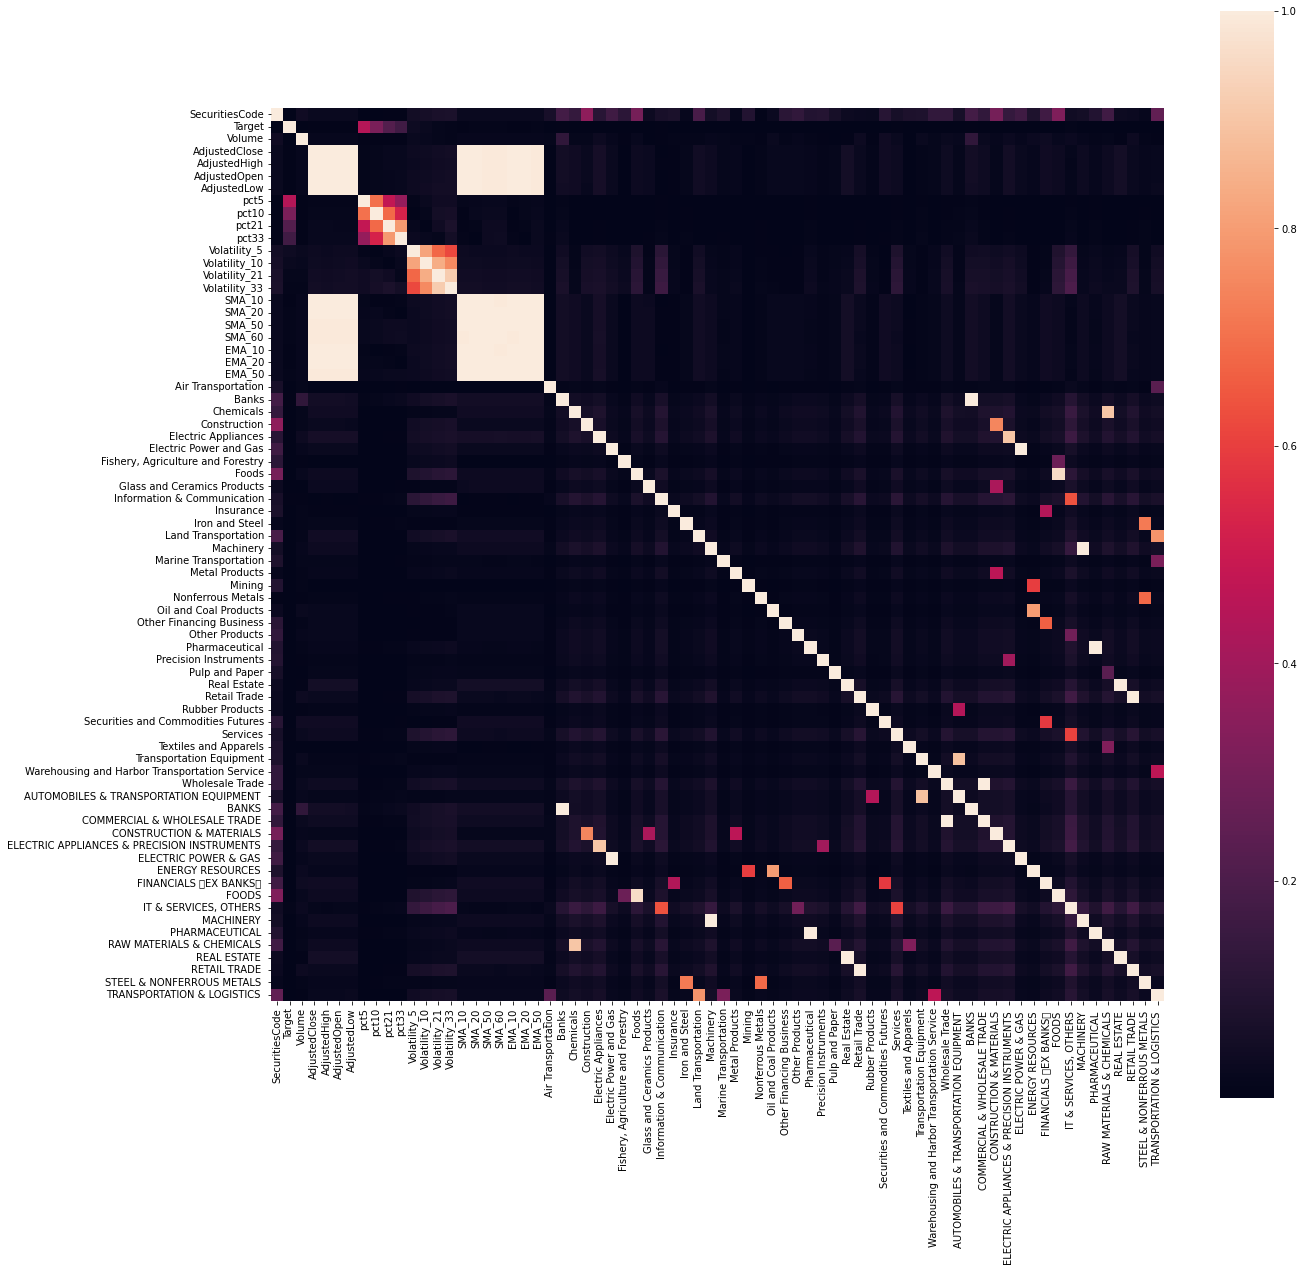

In [128]:
corr_mat = np.abs(X.corr())
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_mat,square = True, ax = ax)

**Removing special characters in the column names**

In [129]:
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

**Drop labels**

In [130]:
y= X["Target"].to_numpy()
X=X.drop(["Target"],axis=1)

### Standarize Values

In [131]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

In [132]:
num_attribs = ['Volume','AdjustedClose',"AdjustedHigh","AdjustedOpen","AdjustedLow","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33",'SMA_10','SMA_20','SMA_50','SMA_60','EMA_10','EMA_20','EMA_50']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
    ])


**Removing special characters in the column names**

ts_fold = TimeSeriesSplit(n_splits=3, gap=10000)

for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]
    print(X_train.shape[0], len(y_train))
    ##### TRAIIIIIIIIIIN
    pipeline_X_df = full_pipeline.fit_transform(X_train)
    pipeline_X_df = pd.DataFrame(pipeline_X_df, columns = num_attribs)
    
    pipeline_X_df.reset_index(drop = True, inplace=True)
    X_train.reset_index(drop = True, inplace=True)
    
    
    X_train.drop(num_attribs,axis=1,inplace=True)
    X_train = pd.concat([X_train,pipeline_X_df], axis=1)
    
    ##### VALIDATION

    pipeline_val_df = full_pipeline.transform(X_valid)
    pipeline_val_df = pd.DataFrame(pipeline_val_df, columns = num_attribs)
   # display(pipeline_val_df)
   # print(num_attribs)
    #display(X_valid)
    pipeline_val_df.reset_index(drop = True, inplace=True)
    X_valid.reset_index(drop = True, inplace=True)
    X_valid.drop(num_attribs,axis=1,inplace=True)
    X_valid = pd.concat([X_valid,pipeline_val_df], axis=1)
    
    
    print(X_train.shape[0], len(y_train))
    print("-------------")
    print(X_valid.shape[0], len(y_val))
    print("***********")

    del X_train, y_train,  X_valid, y_val, pipeline_X_df , pipeline_val_df
    gc.collect()

### Time based Crossvalidation

In [133]:
params = {'n_estimators': 500,
          'num_leaves' : 200,
          'learning_rate': 0.1,
          'colsample_bytree': 0.9,
          'subsample': 0.8,
          'reg_alpha': 0.4,
          'metric': 'mae',
          'random_state': 21}

In [145]:
ts_fold = TimeSeriesSplit(n_splits=10,gap=10000)

In [135]:
feat_importance=pd.DataFrame()
sharpe_ratio=[]

In [136]:
for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):
    
    print(f"\n========================== Fold {fold+1} ==========================")
        
    X_train, y_train = X.iloc[train_idx,:], y[train_idx]
    X_valid, y_val = X.iloc[val_idx,:], y[val_idx]
    
    print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
    print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))
    
    
    ##### TRAIIIIIIIIIIN
    """
    pipeline_X_df = full_pipeline.fit_transform(X_train)
    pipeline_X_df = pd.DataFrame(pipeline_X_df, columns = num_attribs)
    
    pipeline_X_df.reset_index(drop = True, inplace=True)
    X_train.reset_index(drop = True, inplace=True)

    X_train.drop(num_attribs,axis=1,inplace=True)
    X_train = pd.concat([X_train,pipeline_X_df], axis=1)
    """
    X_train= X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    ##### VALIDATION
    """
    pipeline_val_df = full_pipeline.transform(X_valid)
    pipeline_val_df = pd.DataFrame(pipeline_val_df, columns = num_attribs)
    pipeline_val_df.reset_index(drop = True, inplace=True)
    X_valid.reset_index(drop = True, inplace=True)
    X_valid.drop(num_attribs,axis=1,inplace=True)
    X_valid = pd.concat([X_valid,pipeline_val_df], axis=1)
    
    """
    X_valid= X_valid.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    X_train.drop(['Date','SecuritiesCode'], axis=1, inplace=True)
    X_val=X_valid[X_valid.columns[~X_valid.columns.isin(['Date','SecuritiesCode'])]]
    val_dates=X_valid.Date.unique()[1:-1]
    print("\nTrain Shape: {} {}, Valid Shape: {} {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))
    
    gbm = LGBMRegressor(**params).fit(X_train, y_train, 
                                      eval_set=[(X_train, y_train), (X_val, y_val)],
                                      verbose=300, 
                                      eval_metric=['mae','mse'])
    y_pred = gbm.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
    feat_importance.set_index(X_train.columns, inplace=True)
        
    rank=[]
    X_val_df=X_valid[X_valid.Date.isin(val_dates)]
    for i in X_val_df.Date.unique():
        temp_df = X_val_df[X_val_df.Date == i].drop(['Date','SecuritiesCode'],axis=1)
        temp_df["pred"] = gbm.predict(temp_df)
        temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
        rank.append(temp_df["Rank"].values)

    stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
    df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,
                  df_prices_feat[df_prices_feat.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
    sharpe=calc_spread_return_sharpe(df)
    sharpe_ratio.append(sharpe)
    print("Valid Sharpe: {}, RMSE: {}, MAE: {}".format(sharpe,rmse,mae))
    
    del X_train, y_train,  X_val, y_val ##, pipeline_val_df, pipeline_X_df
    gc.collect()
    
print("\nAverage cross-validation Sharpe Ratio: {:.4f}, standard deviation = {:.2f}.".format(np.mean(sharpe_ratio),np.std(sharpe_ratio)))


========================== Fold 1 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-06-12 00:00:00
Valid Date range: 2017-06-19 00:00:00 to 2017-12-01 00:00:00

Train Shape: (202033, 70) (202033,), Valid Shape: (212025, 70) (212025,)
[300]	training's l2: 0.000184986	training's l1: 0.00983814	valid_1's l2: 0.000301059	valid_1's l1: 0.0112448
Valid Sharpe: 0.0737230150329446, RMSE: 0.017411170575336574, MAE: 0.011261165415375807

========================== Fold 2 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-11-22 00:00:00
Valid Date range: 2017-12-01 00:00:00 to 2018-05-18 00:00:00

Train Shape: (414058, 70) (414058,), Valid Shape: (212025, 70) (212025,)
[300]	training's l2: 0.00020748	training's l1: 0.0102332	valid_1's l2: 0.000413903	valid_1's l1: 0.0135092
Valid Sharpe: 0.1091617448870187, RMSE: 0.020360574776513103, MAE: 0.013502729338320871

========================== Fold 3 ==========================
Train Date range: 2017-01-04 0

In [137]:
feat_importance['avg'] = feat_importance.mean(axis=1)
feat_importance = feat_importance.sort_values(by='avg',ascending=True)
feat_importance = feat_importance.tail(20)
pal=sns.color_palette("plasma_r", 29).as_hex()[2:]

fig=go.Figure()
for i in range(len(feat_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=feat_importance['avg'][i], 
                       line_color=pal[::-1][i],opacity=0.7,line_width=4))
    fig.add_trace(go.Scatter(x=feat_importance['avg'], y=feat_importance.index, mode='markers', 
                             marker_color=pal[::-1], marker_size=8,
                             hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
    fig.update_layout(title='Overall Feature Importance', 
                      xaxis=dict(title='Average Importance',zeroline=False),
                      yaxis_showgrid=False, margin=dict(l=120,t=80),
                      height=700, width=800)
fig.show()

### Optuna optimization

https://www.kaggle.com/code/swimmy/lgbm-model-fe-portfolio

https://www.kaggle.com/code/marketneutral/purged-time-series-cv-xgboost-optuna/notebook

In [146]:
def objective(trial):

    # Optuna suggest params
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 350, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.10),
        'subsample': trial.suggest_uniform('subsample', 0.50, 0.90),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 0.90),
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0)
    }

    for fold, (train_idx, val_idx) in enumerate(ts_fold.split(X, y)):

        print(f"\n========================== Fold {fold+1} ==========================")

        X_train, y_train = X.iloc[train_idx,:], y[train_idx]
        X_valid, y_val = X.iloc[val_idx,:], y[val_idx]

        print("Train Date range: {} to {}".format(X_train.Date.min(),X_train.Date.max()))
        print("Valid Date range: {} to {}".format(X_valid.Date.min(),X_valid.Date.max()))


        ##### TRAIIIIIIIIIIN
        """
        pipeline_X_df = full_pipeline.fit_transform(X_train)
        pipeline_X_df = pd.DataFrame(pipeline_X_df, columns = num_attribs)

        pipeline_X_df.reset_index(drop = True, inplace=True)
        X_train.reset_index(drop = True, inplace=True)

        X_train.drop(num_attribs,axis=1,inplace=True)
        X_train = pd.concat([X_train,pipeline_X_df], axis=1)
        """
        X_train= X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

        ##### VALIDATION
        """
        pipeline_val_df = full_pipeline.transform(X_valid)
        pipeline_val_df = pd.DataFrame(pipeline_val_df, columns = num_attribs)
        pipeline_val_df.reset_index(drop = True, inplace=True)
        X_valid.reset_index(drop = True, inplace=True)
        X_valid.drop(num_attribs,axis=1,inplace=True)
        X_valid = pd.concat([X_valid,pipeline_val_df], axis=1)

        """
        X_valid= X_valid.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

        X_train.drop(['Date','SecuritiesCode'], axis=1, inplace=True)
        X_val=X_valid[X_valid.columns[~X_valid.columns.isin(['Date','SecuritiesCode'])]]
        val_dates=X_valid.Date.unique()[1:-1]
        print("\nTrain Shape: {} {}, Valid Shape: {} {}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

        model = LGBMRegressor(**params)
        model.fit(X_train, y_train, 
                                      eval_set=[(X_train, y_train), (X_val, y_val)],
                                      eval_metric=['mae','mse'])

        
        y_pred = gbm.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae = mean_absolute_error(y_val, y_pred)
        #feat_importance["Importance_Fold"+str(fold)]=gbm.feature_importances_
        #feat_importance.set_index(X_train.columns, inplace=True)

        rank=[]
        X_val_df=X_valid[X_valid.Date.isin(val_dates)]
        for i in X_val_df.Date.unique():
            temp_df = X_val_df[X_val_df.Date == i].drop(['Date','SecuritiesCode'],axis=1)
            temp_df["pred"] = gbm.predict(temp_df)
            temp_df["Rank"] = (temp_df["pred"].rank(method="first", ascending=False)-1).astype(int)
            rank.append(temp_df["Rank"].values)

        stock_rank=pd.Series([x for y in rank for x in y], name="Rank")
        df=pd.concat([X_val_df.reset_index(drop=True),stock_rank,
                      df_prices_feat[df_prices_feat.Date.isin(val_dates)]['Target'].reset_index(drop=True)], axis=1)
        sharpe=calc_spread_return_sharpe(df)
        sharpe_ratio.append(sharpe)
        print("Valid Sharpe: {}, RMSE: {}, MAE: {}".format(sharpe,rmse,mae))

        del X_train, y_train,  X_val, y_val ##, pipeline_val_df, pipeline_X_df
        gc.collect()
        
    return np.mean(sharpe_ratio) #,np.std(sharpe_ratio)

**Select the best model, tune the parameters to find the best ones, retrain the WHOLE DATA with the best parameters**

In [147]:
opt = optuna.create_study(direction='maximize',sampler=optuna.samplers.RandomSampler(seed=0))
opt.optimize(objective,n_trials=10)

# Save best parameters
trial = opt.best_trial
params_best = dict(trial.params.items())
params_best['random_seed'] = 0
    
# Create the model with best parameters
model_o = LGBMRegressor(**params_best)#

[I 2022-06-15 18:29:34,000] A new study created in memory with name: no-name-baa21a1f-9203-4110-823e-7cbf4edc37dd



========================== Fold 1 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-06-12 00:00:00
Valid Date range: 2017-06-19 00:00:00 to 2017-12-01 00:00:00

Train Shape: (202033, 70) (202033,), Valid Shape: (212025, 70) (212025,)
[300]	training's l1: 0.0109286	training's l2: 0.000253815	valid_1's l1: 0.01121	valid_1's l2: 0.000295608
[600]	training's l1: 0.0107661	training's l2: 0.000240682	valid_1's l1: 0.0112003	valid_1's l2: 0.000295355

========================== Fold 2 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-11-22 00:00:00
Valid Date range: 2017-12-01 00:00:00 to 2018-05-18 00:00:00

Train Shape: (414058, 70) (414058,), Valid Shape: (212025, 70) (212025,)
[300]	training's l1: 0.0110115	training's l2: 0.000267649	valid_1's l1: 0.013523	valid_1's l2: 0.000411377
[600]	training's l1: 0.0108965	training's l2: 0.000256876	valid_1's l1: 0.0135007	valid_1's l2: 0.000409842

========================== Fold 3 ====================

[I 2022-06-15 18:36:20,103] Trial 0 finished with value: 0.03853497567321999 and parameters: {'n_estimators': 707, 'max_depth': 8, 'learning_rate': 0.06424870384644796, 'subsample': 0.7179532731987588, 'colsample_bytree': 0.6694619197355619, 'reg_alpha': 0.3833332156156664, 'reg_lambda': 0.0562793204741517}. Best is trial 0 with value: 0.03853497567321999.



========================== Fold 1 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-06-12 00:00:00
Valid Date range: 2017-06-19 00:00:00 to 2017-12-01 00:00:00

Train Shape: (202033, 70) (202033,), Valid Shape: (212025, 70) (212025,)
[300]	training's l1: 0.0109573	training's l2: 0.000255232	valid_1's l1: 0.0112153	valid_1's l2: 0.000296076
[600]	training's l1: 0.010805	training's l2: 0.000241639	valid_1's l1: 0.0112119	valid_1's l2: 0.000296076
[900]	training's l1: 0.0106778	training's l2: 0.000231652	valid_1's l1: 0.0112119	valid_1's l2: 0.000296281

========================== Fold 2 ==========================
Train Date range: 2017-01-04 00:00:00 to 2017-11-22 00:00:00
Valid Date range: 2017-12-01 00:00:00 to 2018-05-18 00:00:00

Train Shape: (414058, 70) (414058,), Valid Shape: (212025, 70) (212025,)
[300]	training's l1: 0.0110331	training's l2: 0.000269037	valid_1's l1: 0.013529	valid_1's l2: 0.000411797
[600]	training's l1: 0.0109341	training's l2: 0.000258

[I 2022-06-15 18:44:07,244] Trial 1 finished with value: 0.03752318913354669 and parameters: {'n_estimators': 930, 'max_depth': 10, 'learning_rate': 0.04450973669432, 'subsample': 0.8166900152330658, 'colsample_bytree': 0.7115579679011618, 'reg_alpha': 0.18714500686240676, 'reg_lambda': 5.039489598671215}. Best is trial 0 with value: 0.03853497567321999.


In [152]:
params_best

{'n_estimators': 707,
 'max_depth': 8,
 'learning_rate': 0.06424870384644796,
 'subsample': 0.7179532731987588,
 'colsample_bytree': 0.6694619197355619,
 'reg_alpha': 0.3833332156156664,
 'reg_lambda': 0.0562793204741517,
 'random_seed': 0}

In [154]:
#Shows scores for all trials
optuna.visualization.plot_optimization_history(opt)

In [155]:
# Vizualize parameter importance
optuna.visualization.plot_param_importances(opt)

In [148]:
X1 = X.drop(['Date','SecuritiesCode'], axis=1, inplace=False)
model_o.fit(X1,y)
#X.drop(['Date','SecuritiesCode'], axis=1, inplace=True)

LGBMRegressor(colsample_bytree=0.6694619197355619,
              learning_rate=0.06424870384644796, max_depth=8, n_estimators=707,
              random_seed=0, reg_alpha=0.3833332156156664,
              reg_lambda=0.0562793204741517, subsample=0.7179532731987588)

In [ ]:
del df_prices_feat
gc.collect()

### 5. API Submission

In [149]:
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [150]:
cols=['Date','SecuritiesCode','Open','High','Low','Close','Volume','AdjustmentFactor']
stock_prices_df=stock_prices_df[stock_prices_df.Date>='2021-08-01'][cols]

#cols_fin = ["Date","Volume","AdjustedClose","pct5","pct10","pct21","pct33","Volatility_5","Volatility_10","Volatility_21","Volatility_33","SMA_10","SMA_20","SMA_50","SMA_60","EMA_10","EMA_20","EMA_50"]
cols_fin = col
cols_fin.remove("Target")
counter = 0
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    ## Loading API data and combine it with the dataset
    current_date = prices["Date"].iloc[0]
    if counter == 0:
        df_price_raw = stock_prices_df.loc[stock_prices_df["Date"] < current_date]
    
    df_price_raw = pd.concat([df_price_raw, prices[cols]]).reset_index(drop=True)
    
    ## Feature engineering
    df_price = adjust_price(df_price_raw)
    features = merge_metadata(df_price, stocks2000_df)  
    features = generate_feature(features)
    features = encoding(features) 
    features = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    features = features[X.columns.to_list()]
    
    ## --------- Pipeline
    """
    pipeline_feat_df = full_pipeline.transform(features)
    pipeline_feat_df = pd.DataFrame(pipeline_feat_df, columns = num_attribs)
    pipeline_feat_df.reset_index(drop = True, inplace=True)
    features.reset_index(drop = True, inplace=True)
    features.drop(num_attribs,axis=1,inplace=True)
    features = pd.concat([features,pipeline_feat_df], axis=1)
    """
    ## ---------
    
    feat = features[features.Date == current_date].drop(['SecuritiesCode','Date'],axis=1)
    display(feat)
    
    ## Prediction using the Model
    #feat["pred"] = gbm.predict(feat)
    
    ## Prediction using model with optimized paramat
    feat["pred"] = model_o.predict(feat)

    ## Generate Ranking 0-1999
    feat["Rank"] = (feat["pred"].rank(method="first", ascending=False)-1).astype(int)
    
    ## Input the ranking to the submission file
    sample_prediction["Rank"] = feat["Rank"].values
    display(sample_prediction.head())
    
    ## Input the ranking to the submission file
    assert sample_prediction["Rank"].notna().all()
    assert sample_prediction["Rank"].min() == 0
    assert sample_prediction["Rank"].max() == len(sample_prediction["Rank"]) - 1
    
    ## Submitt prediction file
    env.predict(sample_prediction)
    counter += 1

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


,Date,SecuritiesCode,Volume,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization
0,2021-08-02,1301,20600,1.0,3010.0,2985.0,3010.0,2985.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
1,2021-08-03,1301,9100,1.0,3000.0,3015.0,3020.0,3000.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
2,2021-08-04,1301,12700,1.0,2989.0,2985.0,2989.0,2972.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
3,2021-08-05,1301,26800,1.0,3030.0,2989.0,3035.0,2981.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
4,2021-08-06,1301,10900,1.0,2996.0,3035.0,3040.0,2996.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10


,Volume,AdjustedClose,AdjustedHigh,AdjustedOpen,AdjustedLow,pct5,pct10,pct21,pct33,Volatility_5,Volatility_10,Volatility_21,Volatility_33,SMA_10,SMA_20,SMA_50,SMA_60,EMA_10,EMA_20,EMA_50,AirTransportation,Banks,Chemicals,Construction,ElectricAppliances,ElectricPowerandGas,FisheryAgricultureandForestry,Foods,GlassandCeramicsProducts,InformationCommunication,Insurance,IronandSteel,LandTransportation,Machinery,MarineTransportation,MetalProducts,Mining,NonferrousMetals,OilandCoalProducts,OtherFinancingBusiness,OtherProducts,Pharmaceutical,PrecisionInstruments,PulpandPaper,RealEstate,RetailTrade,RubberProducts,SecuritiesandCommoditiesFutures,Services,TextilesandApparels,TransportationEquipment,WarehousingandHarborTransportationService,WholesaleTrade,AUTOMOBILESTRANSPORTATIONEQUIPMENT,BANKS,COMMERCIALWHOLESALETRADE,CONSTRUCTIONMATERIALS,ELECTRICAPPLIANCESPRECISIONINSTRUMENTS,ELECTRICPOWERGAS,ENERGYRESOURCES,FINANCIALSEXBANKS,FOODS,ITSERVICESOTHERS,MACHINERY,PHARMACEUTICAL,RAWMATERIALSCHEMICALS,REALESTATE,RETAILTRADE,STEELNONFERROUSMETALS,TRANSPORTATIONLOGISTICS
85,8900,2971.0,2982.0,2982.0,2965.0,-0.006732,0.023225,0.093908,0.021542,0.012787,0.010636,0.014061,0.015689,2969.8,3017.90,3027.10,3037.666667,2971.0,2971.0,2971.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
171,1360800,589.0,599.0,592.0,588.0,-0.037351,0.003396,0.078098,0.112054,0.008705,0.015544,0.019127,0.016932,583.4,598.50,626.76,628.383333,589.0,589.0,589.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
257,125900,2377.0,2388.0,2368.0,2360.0,-0.045435,-0.005469,0.097181,0.124106,0.008615,0.013454,0.015080,0.013963,2331.7,2383.65,2529.92,2551.966667,2377.0,2377.0,2377.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
343,81100,1224.0,1239.0,1230.0,1224.0,0.019608,0.090686,0.176471,0.191993,0.018463,0.014261,0.011966,0.011624,1254.9,1315.00,1415.92,1451.816667,1224.0,1224.0,1224.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
429,6200,1351.0,1372.0,1339.0,1339.0,0.022206,0.051073,0.122132,0.081421,0.016534,0.012212,0.012299,0.012915,1374.1,1407.75,1457.22,1473.483333,1351.0,1351.0,1351.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171655,65300,517.0,531.0,528.0,516.0,0.021277,0.090909,0.197292,0.098646,0.027837,0.021519,0.022232,0.024255,533.1,558.60,563.02,563.966667,517.0,517.0,517.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
171741,29100,785.0,800.0,796.0,785.0,-0.015287,0.008917,0.047134,0.121019,0.012773,0.016062,0.015273,0.016153,789.5,800.90,846.24,857.733333,785.0,785.0,785.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
171827,6200,1627.0,1653.0,1645.0,1627.0,0.032575,0.060234,0.056546,0.044868,0.005328,0.007613,0.006306,0.006767,1681.8,1700.90,1712.56,1720.183333,1627.0,1627.0,1627.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
171913,7800,2418.0,2433.0,2394.0,2393.0,-0.024814,-0.012821,0.014888,-0.002481,0.010325,0.009556,0.007744,0.007076,2379.1,2395.90,2417.56,2439.616667,2418.0,2418.0,2418.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


,Date,SecuritiesCode,Rank
0,2021-12-06,1301,1154
1,2021-12-06,1332,374
2,2021-12-06,1333,219
3,2021-12-06,1375,1569
4,2021-12-06,1376,1639


,Date,SecuritiesCode,Volume,CumulativeAdjustmentFactor,AdjustedClose,AdjustedOpen,AdjustedHigh,AdjustedLow,Name,Section/Products,NewMarketSegment,33SectorCode,33SectorName,17SectorCode,17SectorName,NewIndexSeriesSizeCode,NewIndexSeriesSize,IssuedShares,MarketCapitalization
0,2021-08-02,1301,20600,1.0,3010.0,2985.0,3010.0,2985.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
1,2021-08-03,1301,9100,1.0,3000.0,3015.0,3020.0,3000.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
2,2021-08-04,1301,12700,1.0,2989.0,2985.0,2989.0,2972.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
3,2021-08-05,1301,26800,1.0,3030.0,2989.0,3035.0,2981.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10
4,2021-08-06,1301,10900,1.0,2996.0,3035.0,3040.0,2996.0,"KYOKUYO CO.,LTD.",First Section (Domestic),Prime Market,50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,10928283.0,3.365911e+10


,Volume,AdjustedClose,AdjustedHigh,AdjustedOpen,AdjustedLow,pct5,pct10,pct21,pct33,Volatility_5,Volatility_10,Volatility_21,Volatility_33,SMA_10,SMA_20,SMA_50,SMA_60,EMA_10,EMA_20,EMA_50,AirTransportation,Banks,Chemicals,Construction,ElectricAppliances,ElectricPowerandGas,FisheryAgricultureandForestry,Foods,GlassandCeramicsProducts,InformationCommunication,Insurance,IronandSteel,LandTransportation,Machinery,MarineTransportation,MetalProducts,Mining,NonferrousMetals,OilandCoalProducts,OtherFinancingBusiness,OtherProducts,Pharmaceutical,PrecisionInstruments,PulpandPaper,RealEstate,RetailTrade,RubberProducts,SecuritiesandCommoditiesFutures,Services,TextilesandApparels,TransportationEquipment,WarehousingandHarborTransportationService,WholesaleTrade,AUTOMOBILESTRANSPORTATIONEQUIPMENT,BANKS,COMMERCIALWHOLESALETRADE,CONSTRUCTIONMATERIALS,ELECTRICAPPLIANCESPRECISIONINSTRUMENTS,ELECTRICPOWERGAS,ENERGYRESOURCES,FINANCIALSEXBANKS,FOODS,ITSERVICESOTHERS,MACHINERY,PHARMACEUTICAL,RAWMATERIALSCHEMICALS,REALESTATE,RETAILTRADE,STEELNONFERROUSMETALS,TRANSPORTATIONLOGISTICS
86,19100,3065.0,3065.0,2998.0,2990.0,-0.053834,-0.006525,0.014682,-0.004894,0.013389,0.015034,0.012960,0.016617,2971.8,3017.90,3027.10,3037.333333,3065.0,3065.0,3065.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
173,6449200,556.0,569.0,569.0,535.0,0.030576,0.080935,0.188849,0.178058,0.030104,0.022640,0.019843,0.019386,578.9,594.85,624.70,627.250000,556.0,556.0,556.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
260,127300,2409.0,2417.0,2382.0,2371.0,-0.054795,-0.013699,0.080531,0.101287,0.008071,0.014009,0.015568,0.014251,2335.0,2374.70,2524.42,2548.933333,2409.0,2409.0,2409.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
347,128600,1264.0,1266.0,1227.0,1227.0,-0.037184,0.043513,0.121044,0.170095,0.019705,0.019123,0.014619,0.012941,1249.4,1307.55,1409.16,1445.466667,1264.0,1264.0,1264.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
434,5800,1395.0,1395.0,1374.0,1366.0,-0.033692,0.013620,0.075269,0.056631,0.018690,0.016936,0.014699,0.014120,1372.2,1402.80,1453.52,1471.550000,1395.0,1395.0,1395.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173651,57800,535.0,535.0,526.0,524.0,-0.028037,0.035514,0.185047,0.056075,0.031483,0.025065,0.023081,0.025092,531.2,555.35,562.06,563.333333,535.0,535.0,535.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
173738,48500,805.0,806.0,795.0,792.0,-0.045963,0.002484,0.045963,0.096894,0.014561,0.017030,0.015371,0.016870,789.3,799.35,844.10,855.783333,805.0,805.0,805.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173825,6600,1620.0,1640.0,1640.0,1620.0,0.037037,0.077778,0.060494,0.057407,0.004276,0.004407,0.006298,0.006590,1669.2,1695.90,1709.86,1718.050000,1620.0,1620.0,1620.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
173912,5200,2440.0,2440.0,2437.0,2423.0,-0.045902,-0.011475,0.002459,-0.007787,0.002703,0.009420,0.008003,0.007221,2381.9,2395.90,2415.32,2438.183333,2440.0,2440.0,2440.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


,Date,SecuritiesCode,Rank
0,2021-12-07,1301,663
1,2021-12-07,1332,1925
2,2021-12-07,1333,707
3,2021-12-07,1375,1307
4,2021-12-07,1376,1285


sharpe=calc_spread_return_sharpe(sample_prediction)
sharpe